In [7]:
import os
import pandas as pd
import torch
from torch.utils.data import Dataset
from PIL import Image
from torchvision import transforms
from typing import Tuple, List
import torch
import torch.nn as nn
import time
import torch.optim as optim
import torch.nn as nn
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import random
from torch.utils.data import DataLoader, random_split


class CustomPoseDataset(Dataset):
    def __init__(self, image_dir: str, csv_file: str):
        self.image_dir = image_dir
        self.transform = transforms.Compose([
                                        transforms.Resize((64, 64), interpolation=Image.BICUBIC),
                                        transforms.ToTensor(),
                                        transforms.Normalize(mean=(0.45, 0.45, 0.45), std=(0.25, 0.25, 0.25)),
                                        ])

        self.data = pd.read_csv(csv_file)
        self.image_files = self.data['NAME'].tolist()
        
        data = self.data.drop(columns=['Unnamed: 0','NAME', 'Activity', 'Category', 'Scale',
                                             'pelvis_X', 'pelvis_Y', 'thorax_X', 'thorax_Y'])
       
        self.points = data.values.tolist()

    def __len__(self) -> int:
        return len(self.image_files)

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor]:
        image_file = self.image_files[idx]
        image_path = os.path.join(self.image_dir, image_file)
        image = Image.open(image_path).convert('RGB')

        original_width, original_height = image.size  

        points = self.points[idx]
        points = torch.tensor(points, dtype=torch.float32)

        points[::2] *= (64 / original_width)  
        points[1::2] *= (64 / original_height) 

        image = self.transform(image)

        return image, points


In [8]:
dataset = CustomPoseDataset(
    image_dir='/kaggle/input/mpii-dataset-for-python/dataset/images',
    csv_file='/kaggle/input/mpii-dataset-for-python/dataset/mpii_dataset.csv'
)

dataset_size = len(dataset)
train_size = int(0.8 * dataset_size)
test_size = dataset_size - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_dataloader = DataLoader(train_dataset, batch_size=256, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=256, shuffle=False)


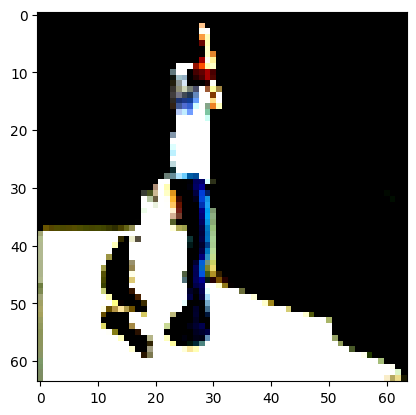

In [9]:
image, points = dataset[1000]
plt.imshow((image).permute((1,2,0)))

In [10]:
BODY_KEYPOINTS = 14

class MyPoseNet(nn.Module):
    def __init__(self):
        super(MyPoseNet, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.feature_size = self._calculate_feature_size()
        
        self.fc1 = nn.Linear(in_features=self.feature_size, out_features=256)  
        self.relu4 = nn.ReLU()
        self.fc2 = nn.Linear(in_features=256, out_features=BODY_KEYPOINTS * 2) 
        
    def _calculate_feature_size(self):
        dummy_input = torch.zeros(1, 3, 64, 64)
        x = self.relu1(self.bn1(self.conv1(dummy_input)))
        x = self.pool1(x)
        
        x = self.relu2(self.bn2(self.conv2(x)))
        x = self.pool2(x)
        
        x = self.relu3(self.bn3(self.conv3(x)))
        x = self.pool3(x)
        
        x = x.view(x.size(0), -1)
        return x.size(1)
    
    def forward(self, x):
        x = self.relu1(self.conv1(x))
        x = self.pool1(x)
        
        x = self.relu2(self.conv2(x))
        x = self.pool2(x)
        
        x = self.relu3(self.conv3(x))
        x = self.pool3(x)
        
        x = x.view(x.size(0), -1)
        
        x = self.relu4(self.fc1(x))
        x = self.fc2(x)  
        
        return x



In [11]:
def test_loop(dataloader, model, loss_fn, device, threshold=30.0, num_keypoints=14):
    model.eval() 
    
    total_loss = 0.0
    num_correct = 0
    total_points = 0
        
    with torch.no_grad():  
        for images, keypoints in dataloader:
            images, keypoints = images.to(device), keypoints.to(device)
            outputs = model(images)
            loss = loss_fn(outputs, keypoints)
            total_loss += loss.item()
          
            distance = (outputs - keypoints).norm(dim=1)  
            num_correct += (distance < threshold).sum().item()
            total_points += keypoints.size(0) 
    
    avg_loss = total_loss / len(dataloader.dataset)
    accuracy = num_correct / total_points  
    
    print(f'Test Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}')
    return avg_loss

In [12]:
from tqdm import tqdm

def train_loop(dataloader, model, loss_fn, optimizer, device):
    model.train() 
    running_loss = 0.0
    for images, keypoints in tqdm(dataloader, desc="Training", leave=False):
        images, keypoints = images.to(device), keypoints.to(device)
       
        optimizer.zero_grad()
        preds = model(images)
        loss = loss_fn(preds, keypoints)

        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    avg_loss = running_loss / len(dataloader.dataset)
    print(f'Train Loss: {avg_loss:.4f}')
    return avg_loss


In [13]:
def plot_predictions(images, keypoints, predictions, num_keypoints, epoch):
    num_images = len(images)
    num_samples = min(3, num_images)  

    indices = random.sample(range(num_images), num_samples)
    
    fig, axs = plt.subplots(1, num_samples, figsize=(15, 5))
    if num_samples == 1:
        axs = [axs] 

    for i, idx in enumerate(indices):
        ax = axs[i]
        image = images[idx].cpu().numpy().transpose(1, 2, 0)  
        image = (image - image.min()) / (image.max() - image.min())  
        
        ax.imshow(image)
        ax.scatter(keypoints[idx, ::2].cpu().numpy(), keypoints[idx, 1::2].cpu().numpy(), c='r', label='True Keypoints')
        ax.scatter(predictions[idx, ::2].cpu().numpy(), predictions[idx, 1::2].cpu().numpy(), c='b', label='Predicted Keypoints')
        ax.legend()
        ax.axis('off')

    plt.tight_layout()
    plt.savefig(f'epoch_{epoch+1}_predictions.png')
    plt.show()
    

In [21]:
def train_model(model, train_dataloader, test_dataloader, criterion, optimizer, num_epochs=50, device='cpu'):
    model.to(device)
    
    start_time = time.time()  
    
    test_loss_per_epoch = []
    train_loss_per_epoch = []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        
        epoch_start_time = time.time()
        
        train_loss = train_loop(train_dataloader, model, criterion, optimizer, device)
        test_loss = test_loop(test_dataloader, model, criterion, device)

        train_loss_per_epoch.append(train_loss)  
        test_loss_per_epoch.append(test_loss) 
        
        with torch.no_grad():
            images, keypoints = next(iter(test_dataloader)) 
            images, keypoints = images.to(device), keypoints.to(device)
            predictions = model(images)  
        
        plot_predictions(images, keypoints, predictions, BODY_KEYPOINTS, epoch)
        
        epoch_end_time = time.time()        
        epoch_duration = epoch_end_time - epoch_start_time  
        print(f'Epoch {epoch+1}/{num_epochs} completed in {epoch_duration:.2f} seconds', flush=True)

    total_training_time = time.time() - start_time 
    print(f'Training complete. Total time: {total_training_time:.2f} seconds', flush=True)
    
    
    plt.figure(figsize=(10, 5))
    plt.plot(range(num_epochs), train_loss_per_epoch, label='Training Loss')
    plt.plot(range(num_epochs), test_loss_per_epoch, label='Test Loss')
    plt.title('Loss Curves')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

Epoch 1/50


Train Loss: 1.2797
Test Loss: 0.8838, Accuracy: 0.0161


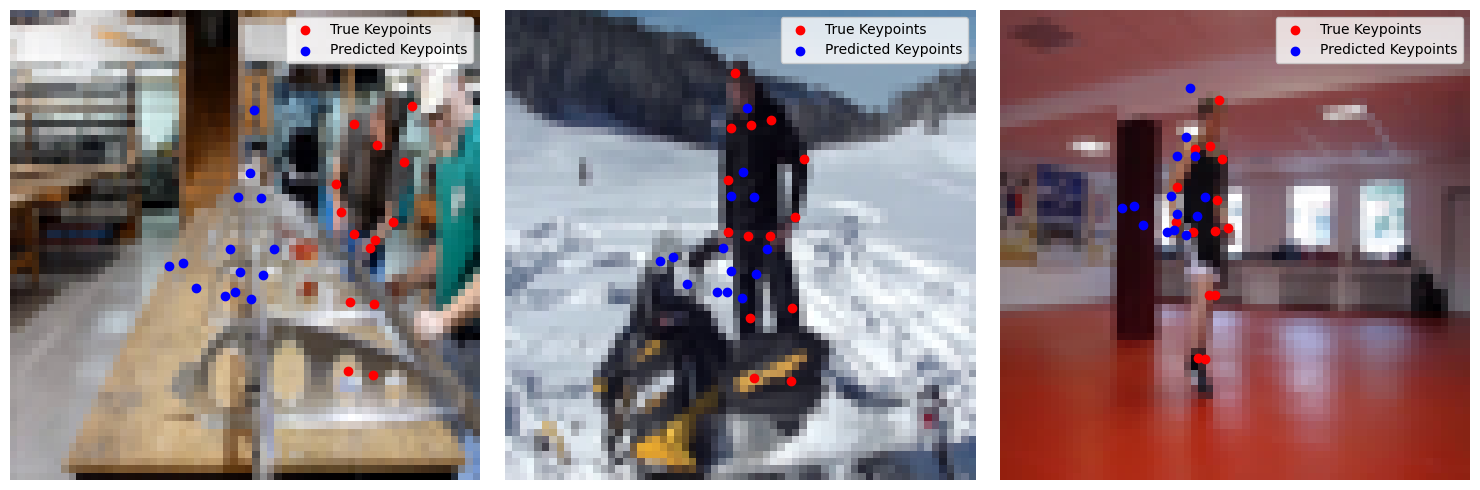

Epoch 1/50 completed in 527.47 seconds
Epoch 2/50


Train Loss: 0.8338
Test Loss: 0.8346, Accuracy: 0.0216


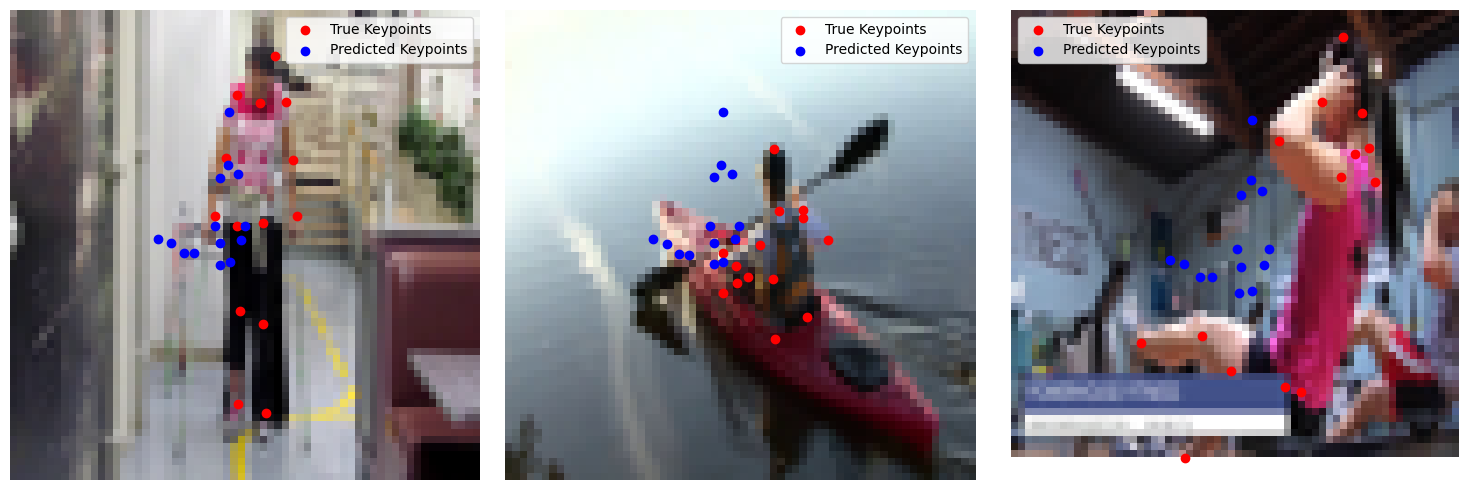

Epoch 2/50 completed in 483.52 seconds
Epoch 3/50


Train Loss: 0.7886
Test Loss: 0.7933, Accuracy: 0.0207


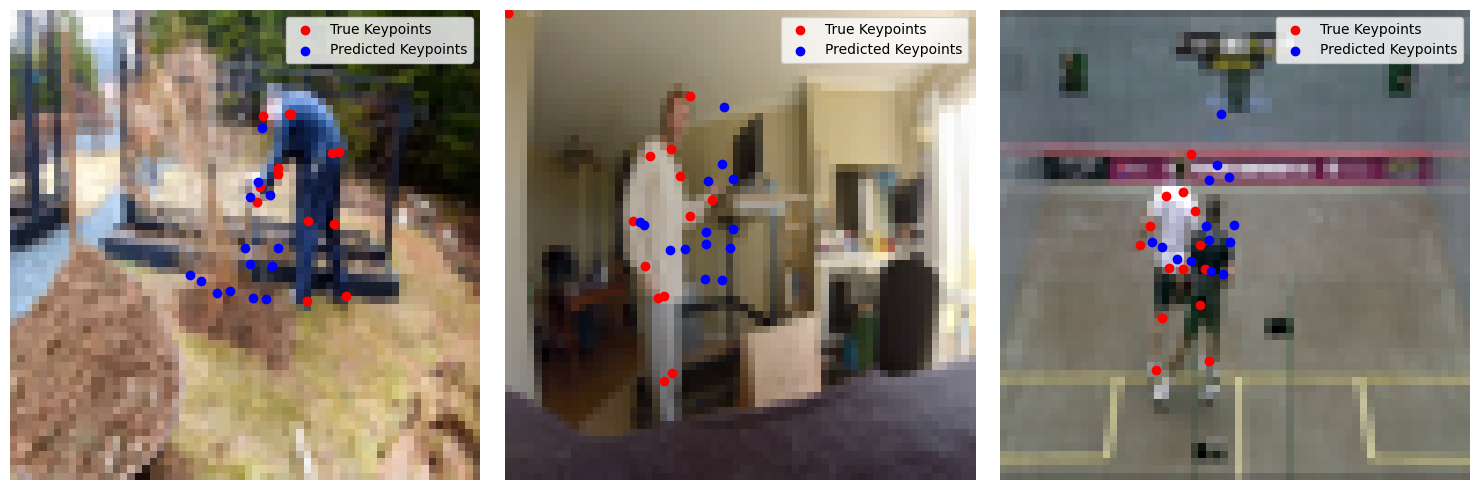

Epoch 3/50 completed in 472.75 seconds
Epoch 4/50


Train Loss: 0.7486
Test Loss: 0.7599, Accuracy: 0.0406


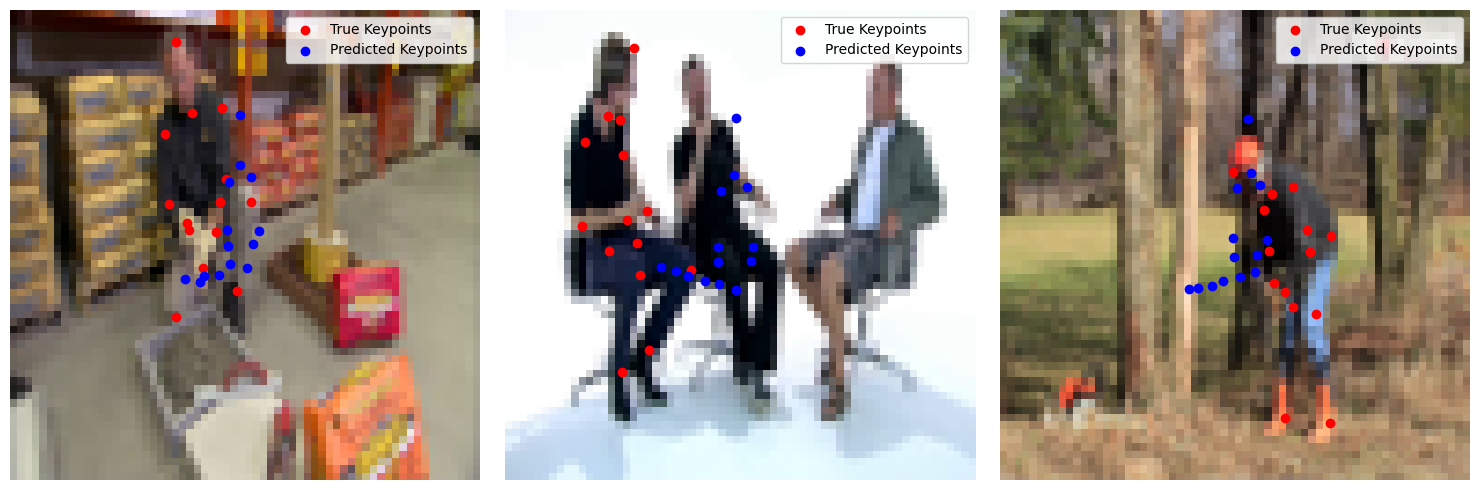

Epoch 4/50 completed in 469.95 seconds
Epoch 5/50


Train Loss: 0.7260
Test Loss: 0.7515, Accuracy: 0.0360


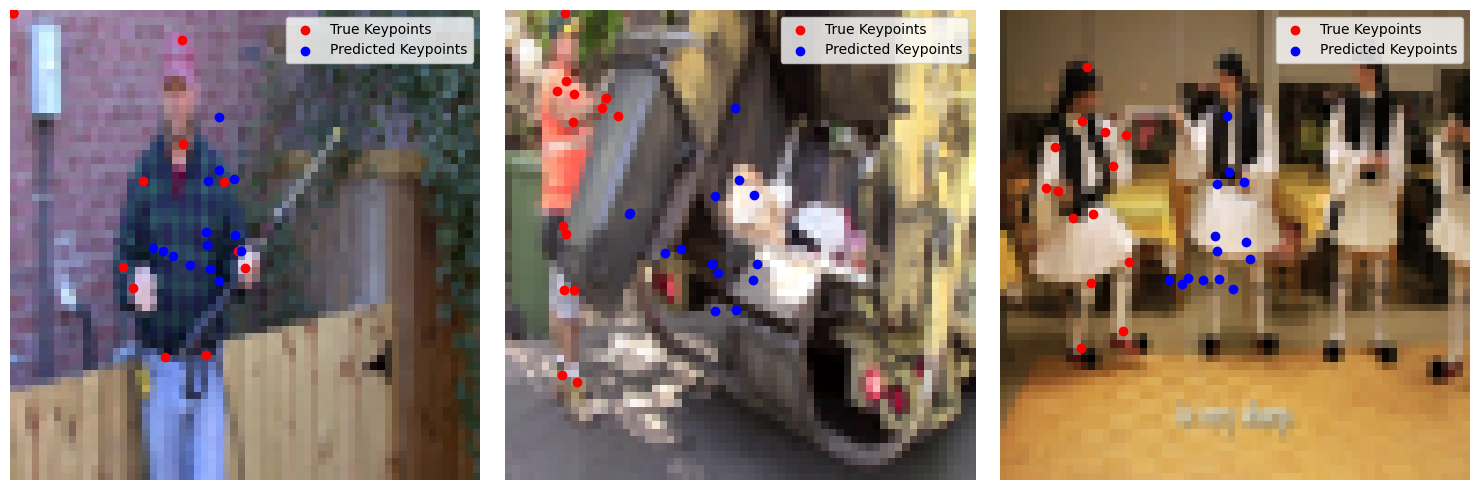

Epoch 5/50 completed in 471.84 seconds
Epoch 6/50


Train Loss: 0.7082
Test Loss: 0.7243, Accuracy: 0.0863


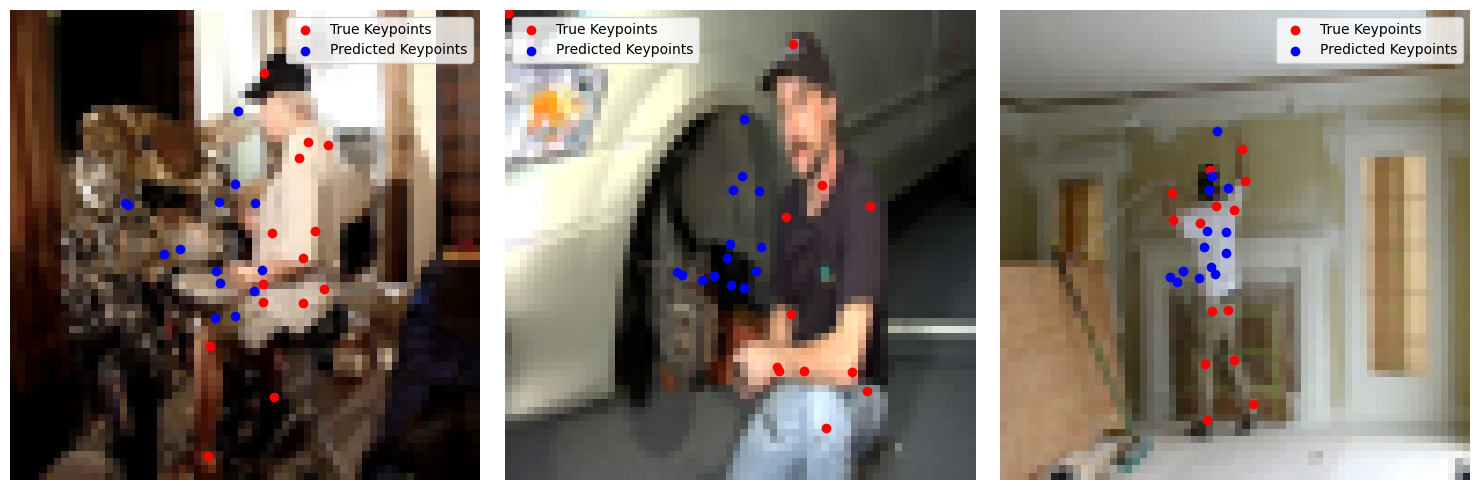

Epoch 6/50 completed in 470.62 seconds
Epoch 7/50


Train Loss: 0.6872
Test Loss: 0.7002, Accuracy: 0.0846


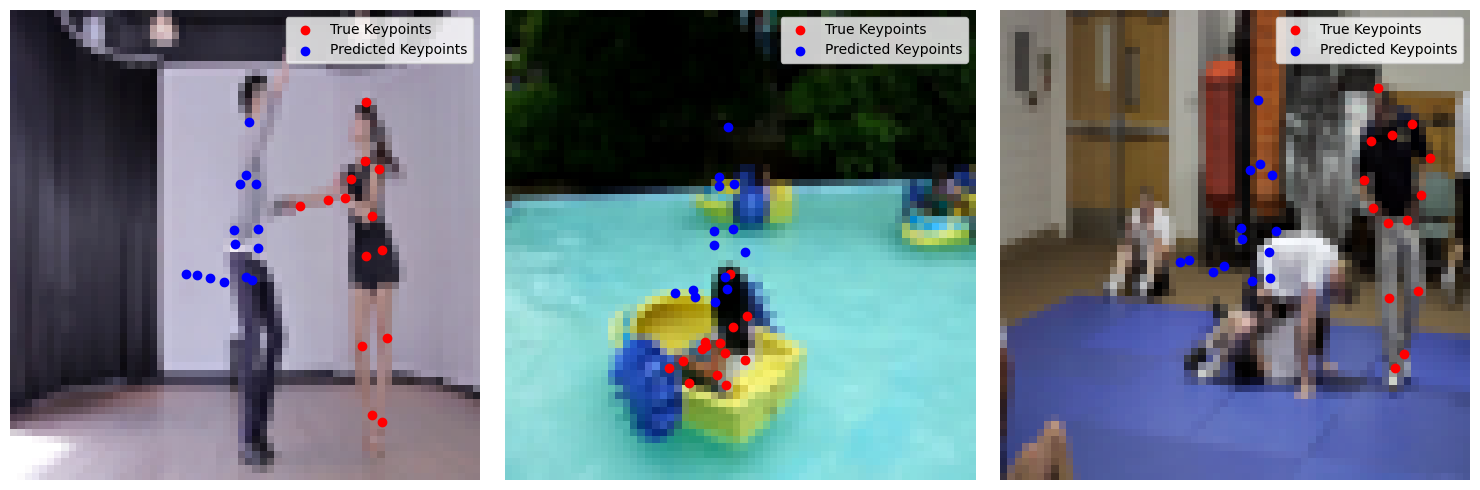

Epoch 7/50 completed in 475.83 seconds
Epoch 8/50


Train Loss: 0.6723
Test Loss: 0.7097, Accuracy: 0.0826


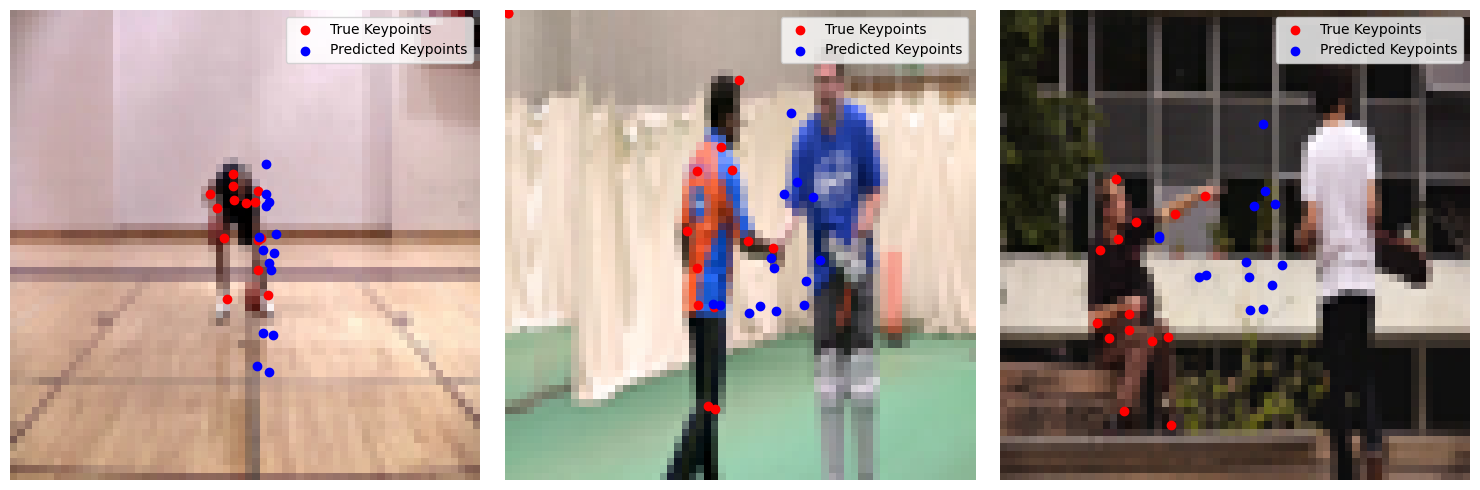

Epoch 8/50 completed in 475.73 seconds
Epoch 9/50


Train Loss: 0.6624
Test Loss: 0.6791, Accuracy: 0.1117


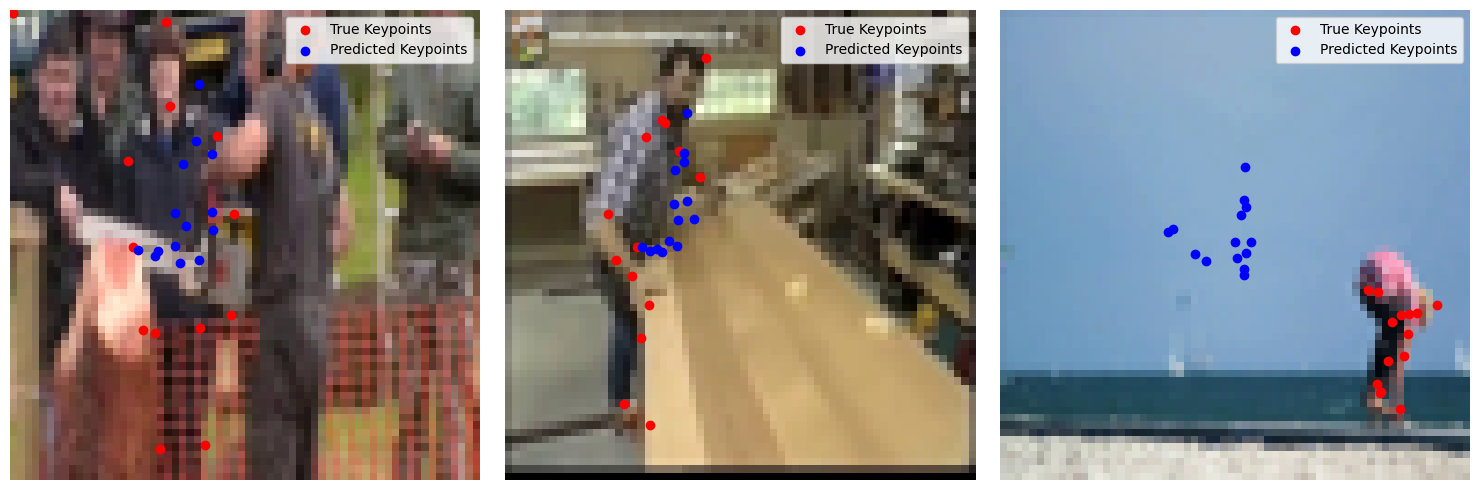

Epoch 9/50 completed in 475.67 seconds
Epoch 10/50


Train Loss: 0.6498
Test Loss: 0.6876, Accuracy: 0.0915


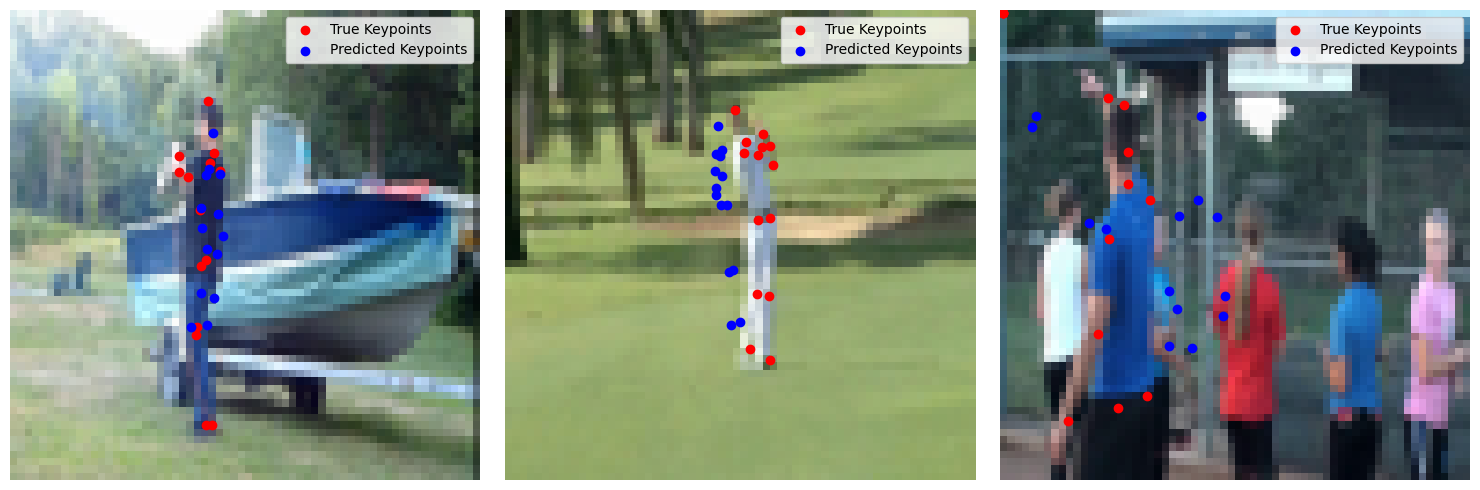

Epoch 10/50 completed in 473.57 seconds
Epoch 11/50


Train Loss: 0.6444
Test Loss: 0.6874, Accuracy: 0.0932


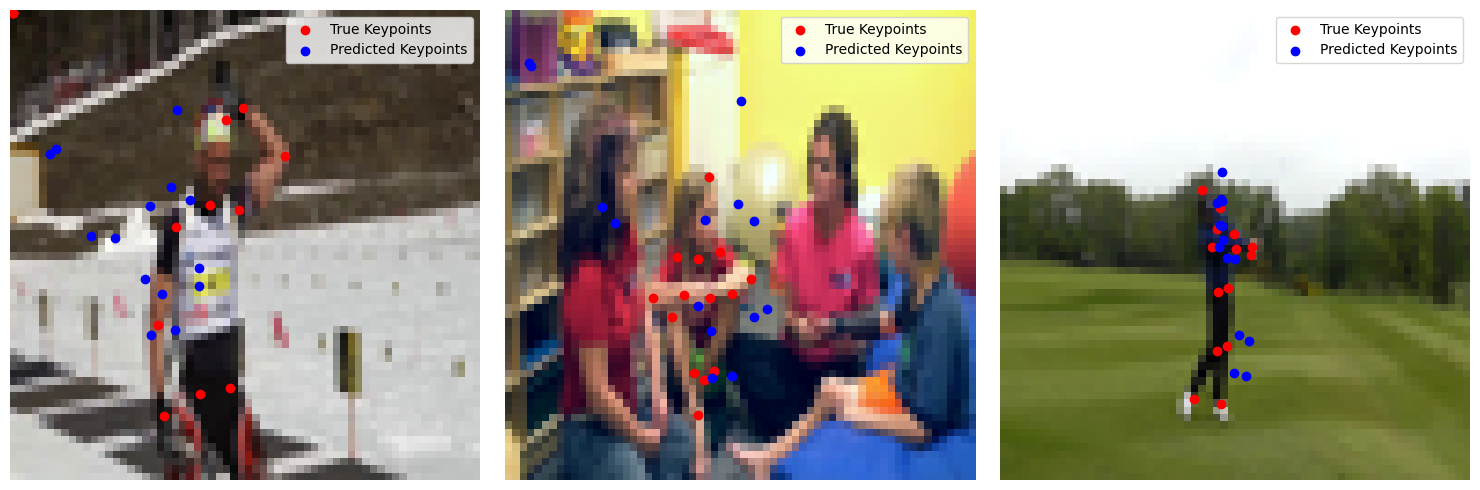

Epoch 11/50 completed in 468.37 seconds
Epoch 12/50


Train Loss: 0.6354
Test Loss: 0.6605, Accuracy: 0.1298


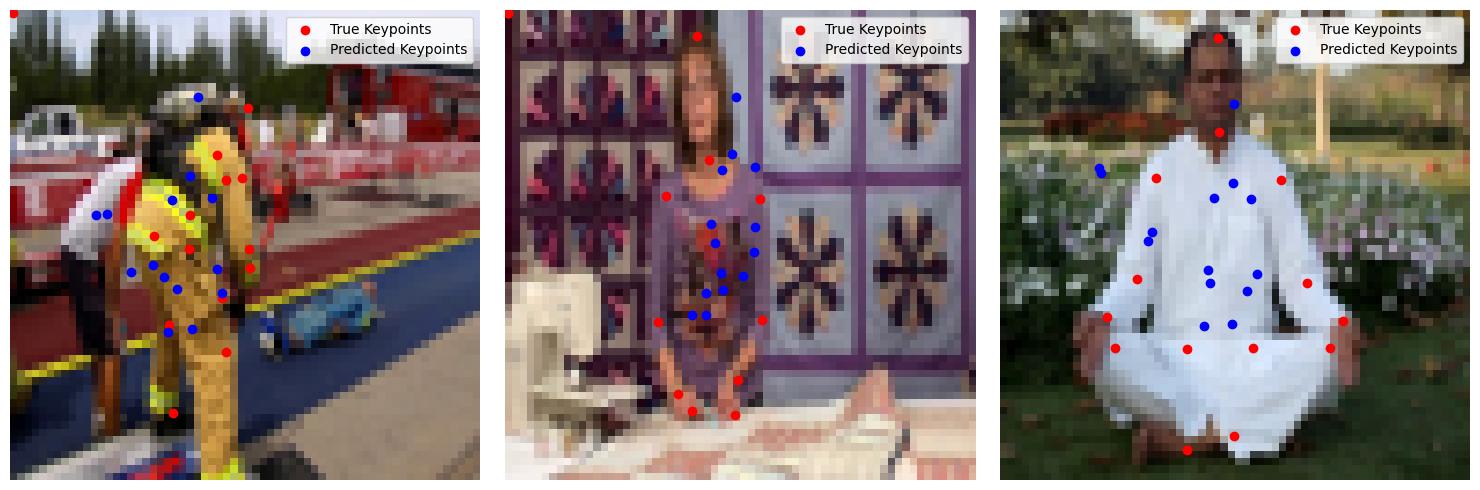

Epoch 12/50 completed in 470.87 seconds
Epoch 13/50


Train Loss: 0.6279
Test Loss: 0.6602, Accuracy: 0.1226


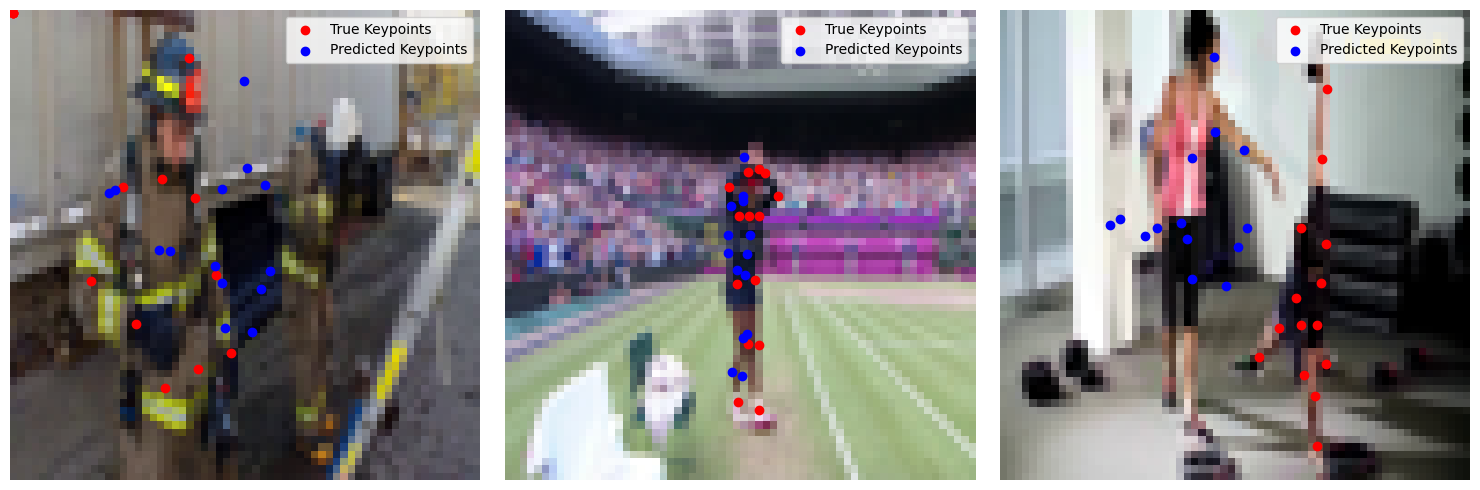

Epoch 13/50 completed in 470.07 seconds
Epoch 14/50


Train Loss: 0.6279
Test Loss: 0.6526, Accuracy: 0.1214


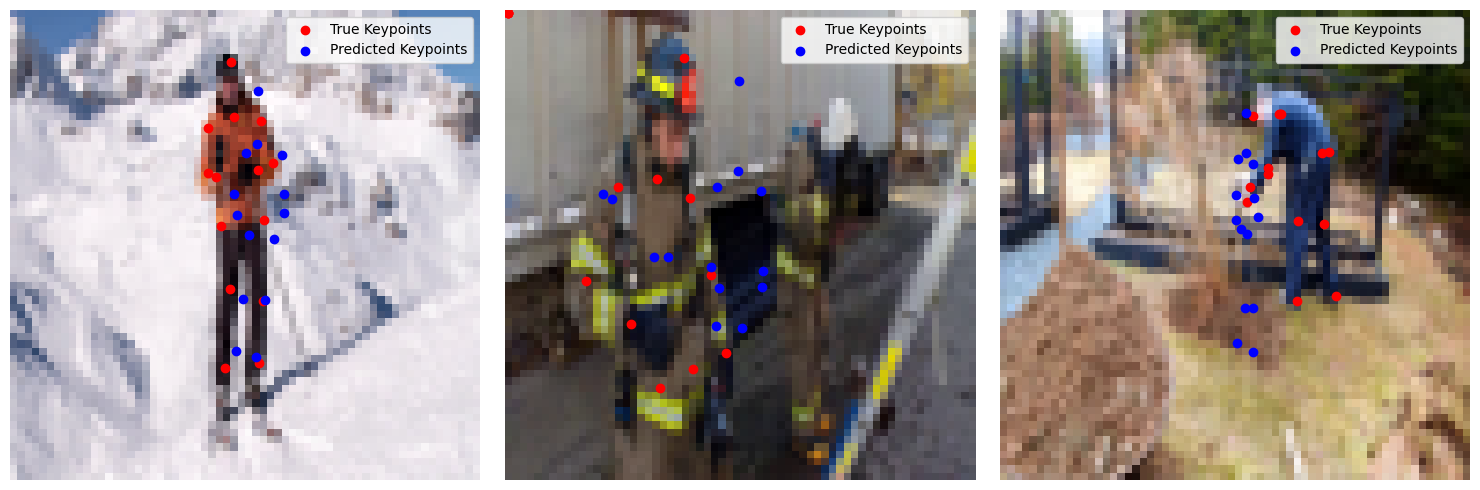

Epoch 14/50 completed in 478.20 seconds
Epoch 15/50


Train Loss: 0.6194
Test Loss: 0.6502, Accuracy: 0.1137


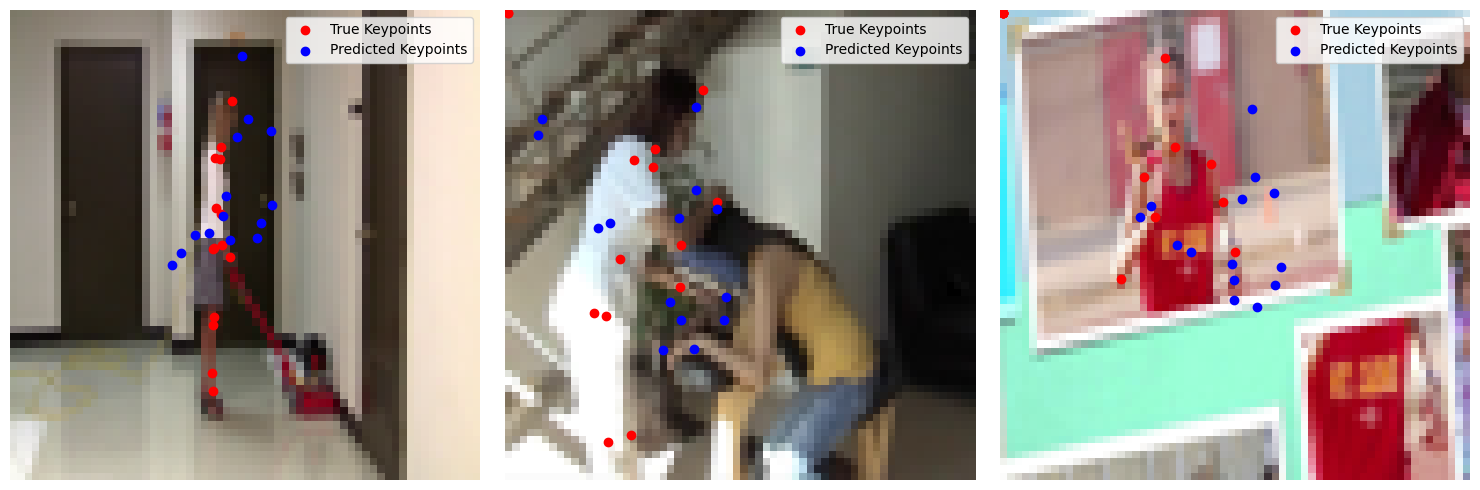

Epoch 15/50 completed in 469.56 seconds
Epoch 16/50


Train Loss: 0.6165
Test Loss: 0.6477, Accuracy: 0.1456


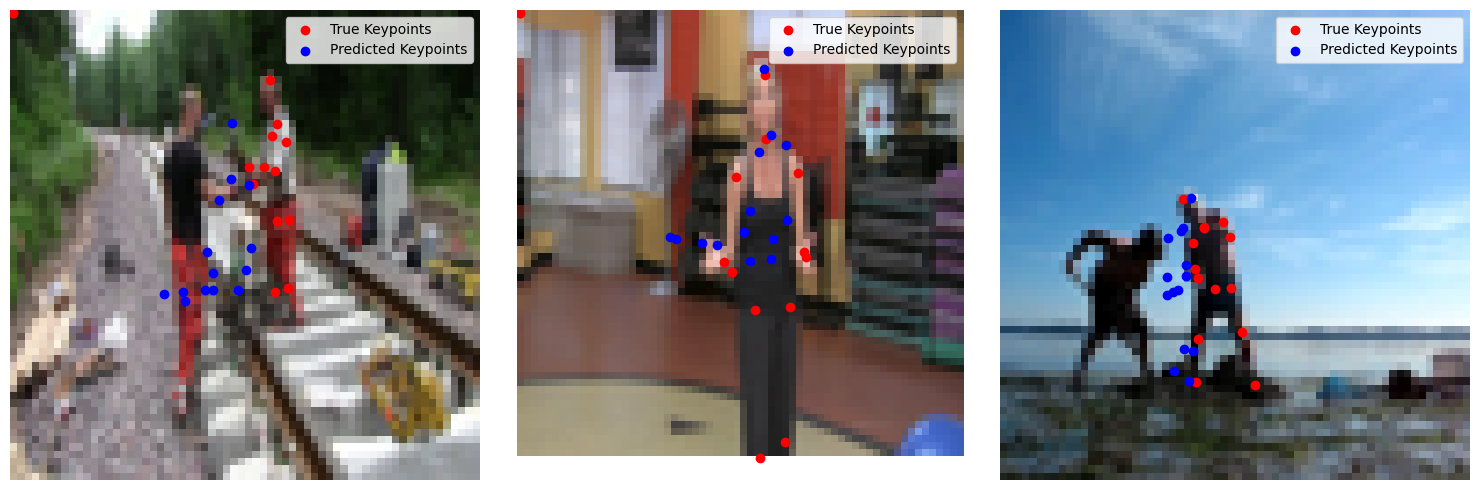

Epoch 16/50 completed in 474.41 seconds
Epoch 17/50


Train Loss: 0.6096
Test Loss: 0.6372, Accuracy: 0.1301


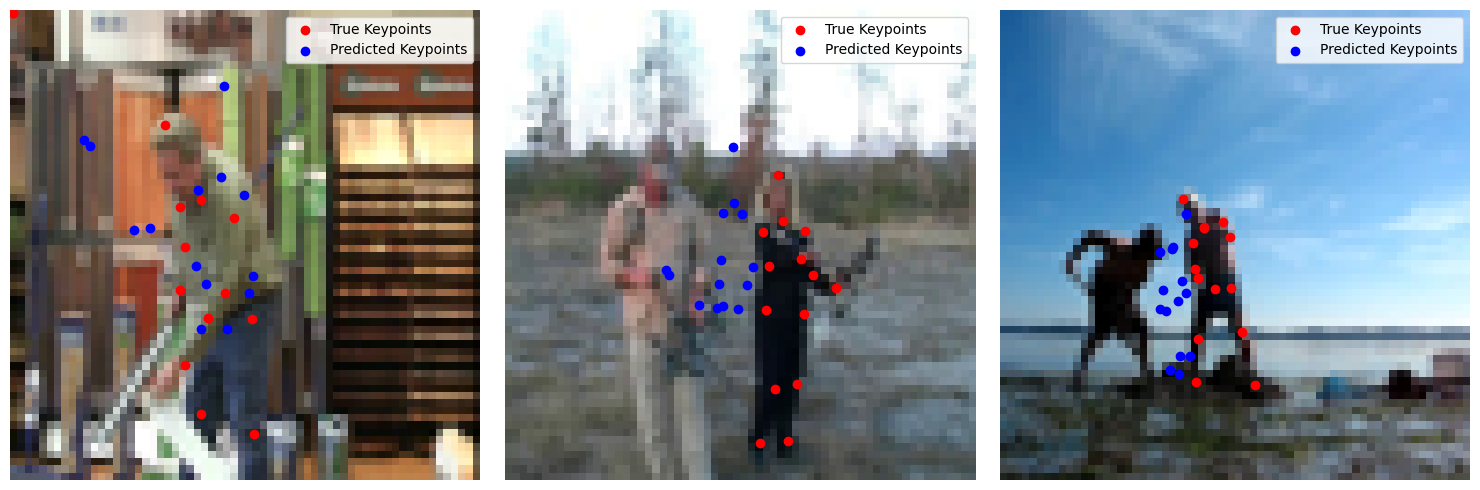

Epoch 17/50 completed in 468.92 seconds
Epoch 18/50


Train Loss: 0.6101
Test Loss: 0.6372, Accuracy: 0.1260


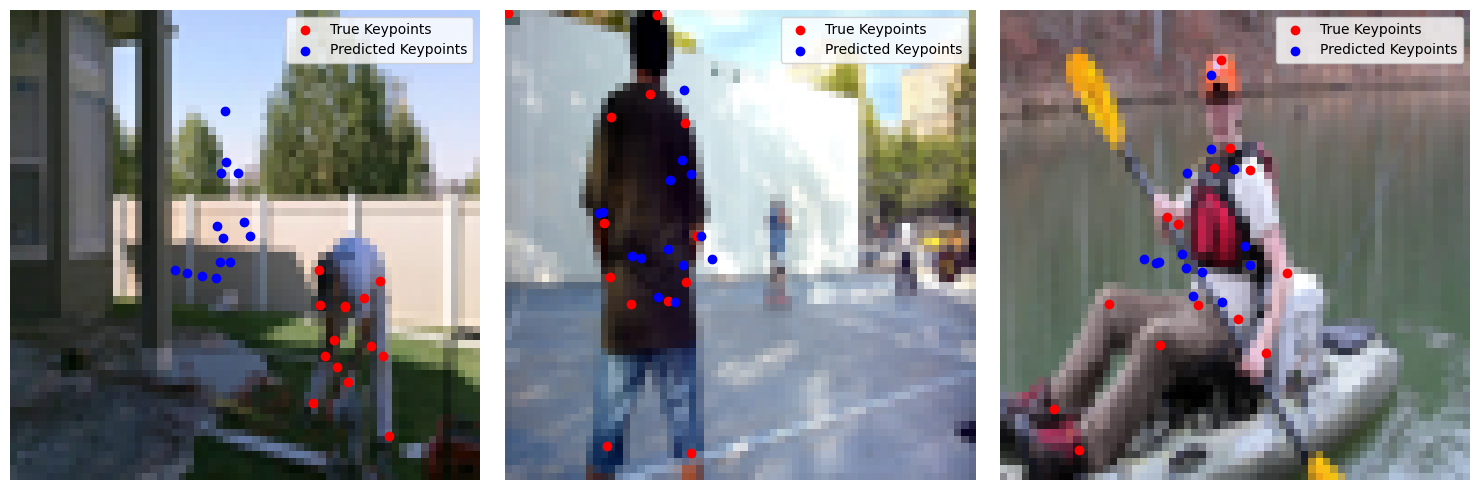

Epoch 18/50 completed in 475.04 seconds
Epoch 19/50


Train Loss: 0.5986
Test Loss: 0.6363, Accuracy: 0.1488


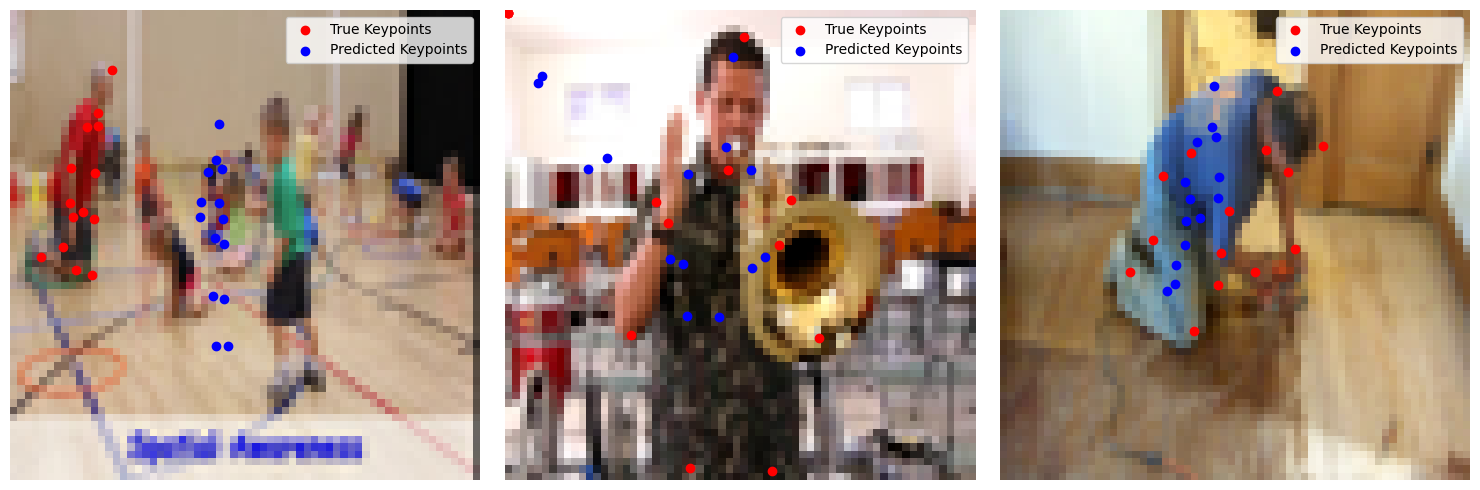

Epoch 19/50 completed in 473.86 seconds
Epoch 20/50


Train Loss: 0.5925
Test Loss: 0.6279, Accuracy: 0.1424


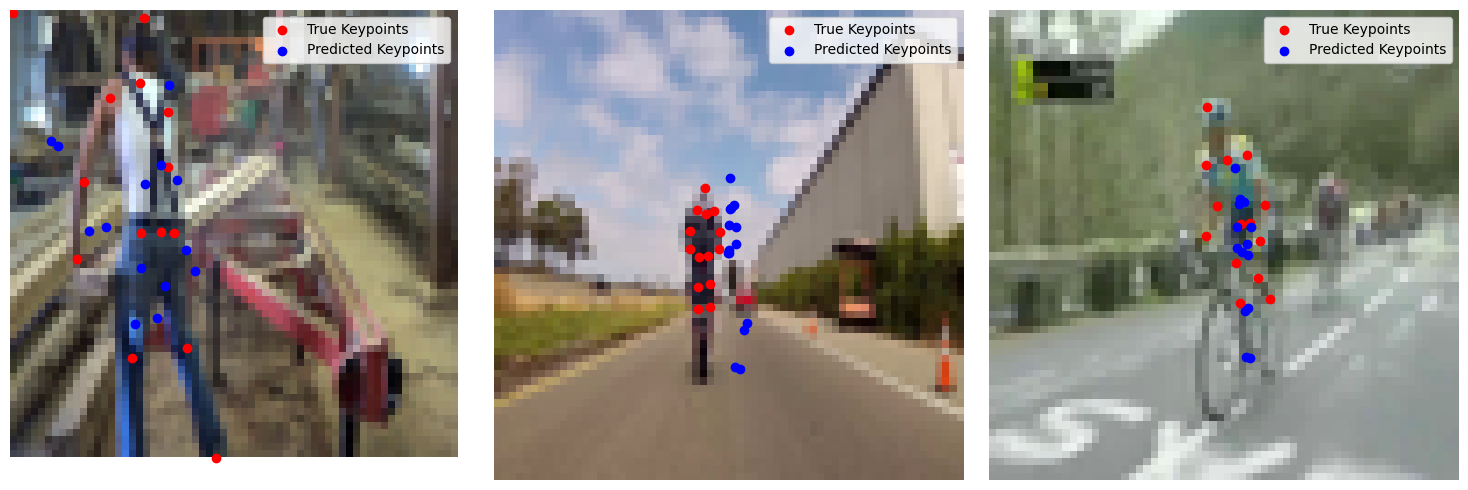

Epoch 20/50 completed in 476.61 seconds
Epoch 21/50


Train Loss: 0.5853
Test Loss: 0.6335, Accuracy: 0.1399


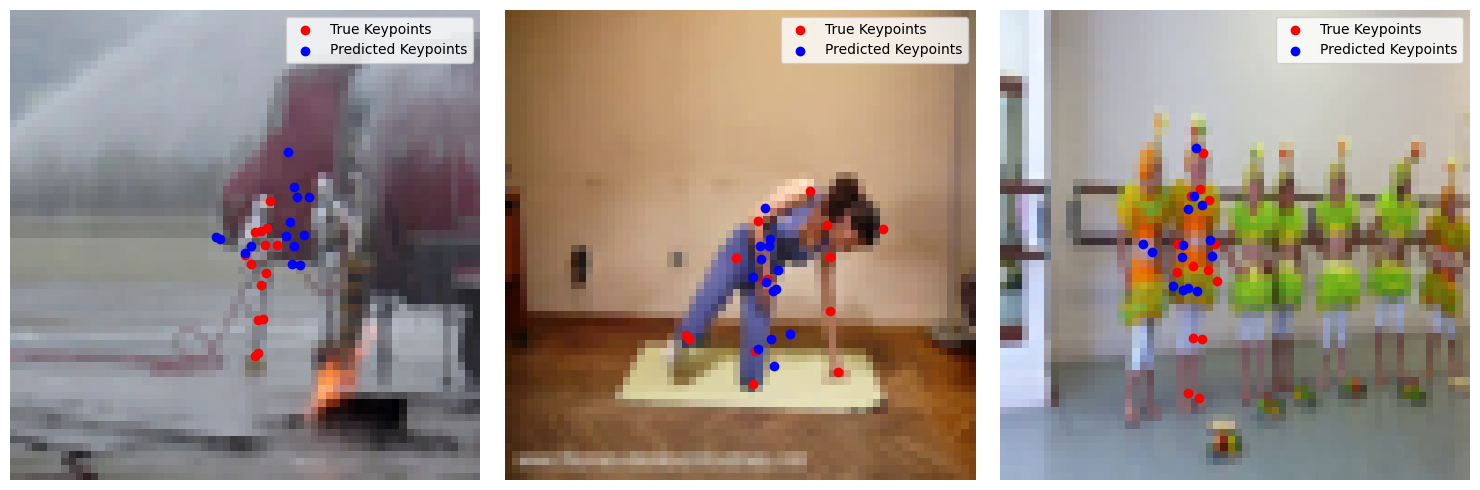

Epoch 21/50 completed in 465.37 seconds
Epoch 22/50


Train Loss: 0.5791
Test Loss: 0.6323, Accuracy: 0.1327


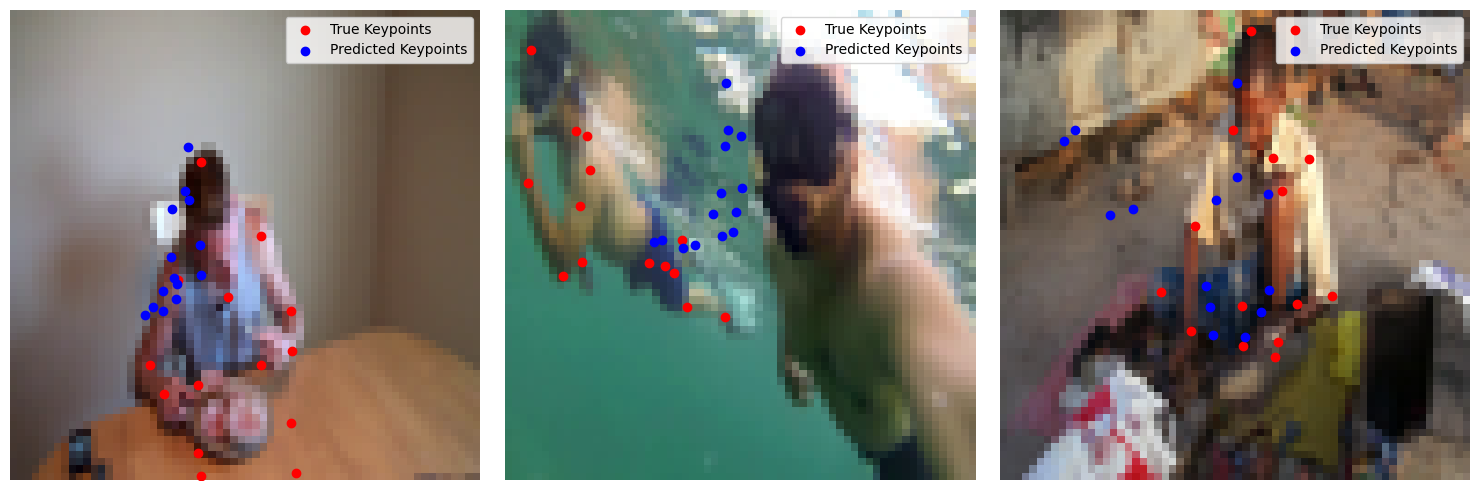

Epoch 22/50 completed in 467.69 seconds
Epoch 23/50


Train Loss: 0.5714
Test Loss: 0.6480, Accuracy: 0.1704


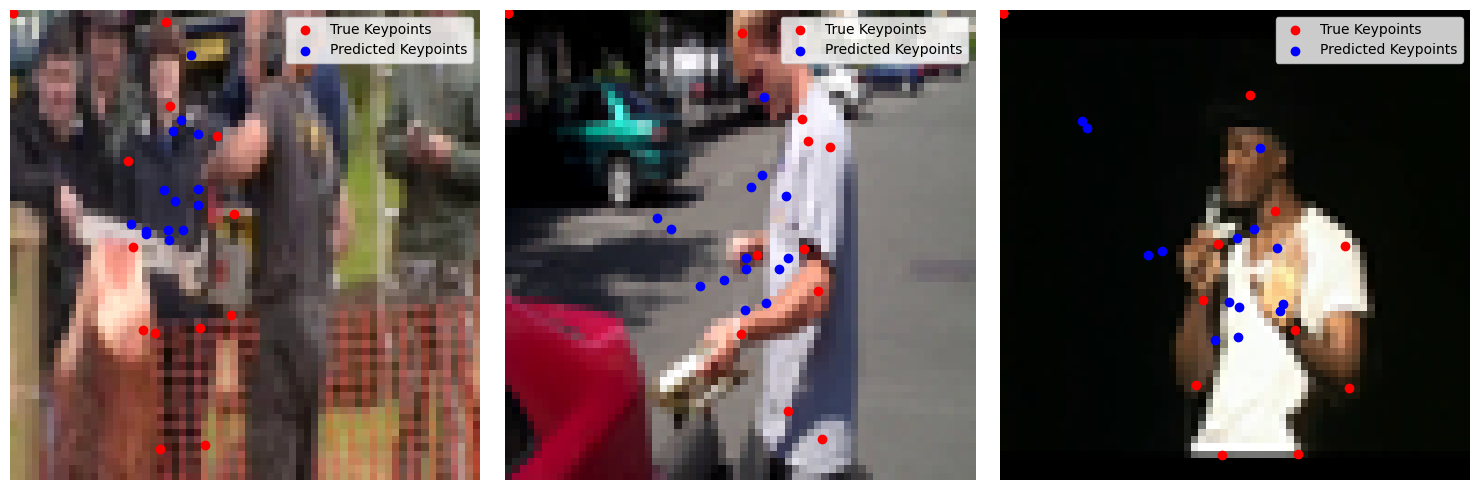

Epoch 23/50 completed in 465.94 seconds
Epoch 24/50


Train Loss: 0.5691
Test Loss: 0.6240, Accuracy: 0.1341


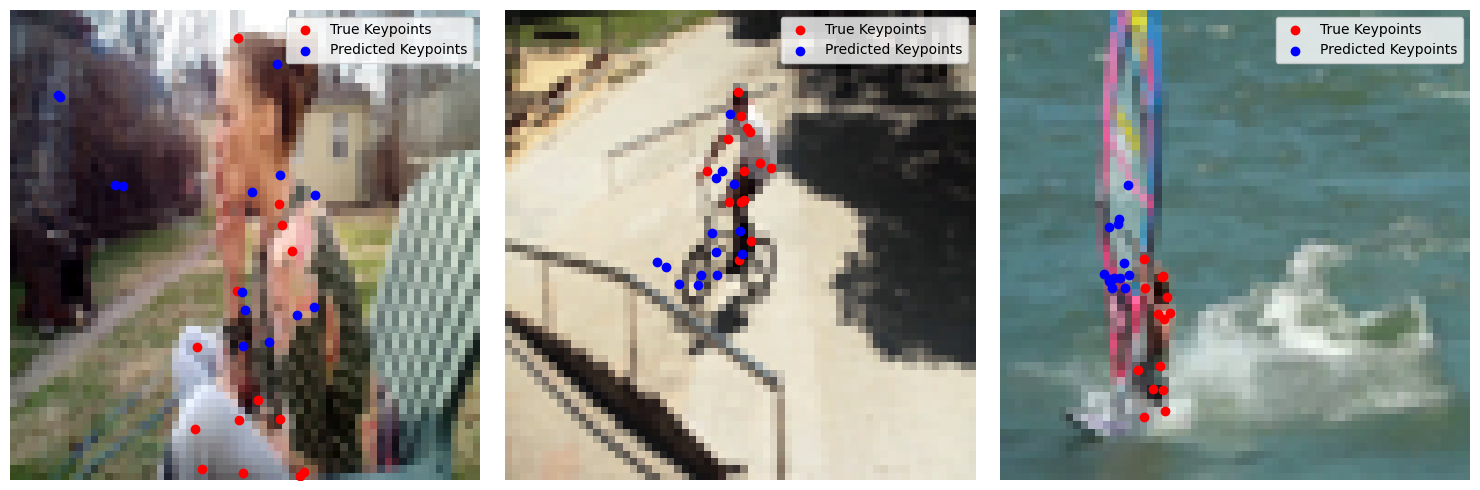

Epoch 24/50 completed in 464.26 seconds
Epoch 25/50


Train Loss: 0.5614
Test Loss: 0.6210, Accuracy: 0.1597


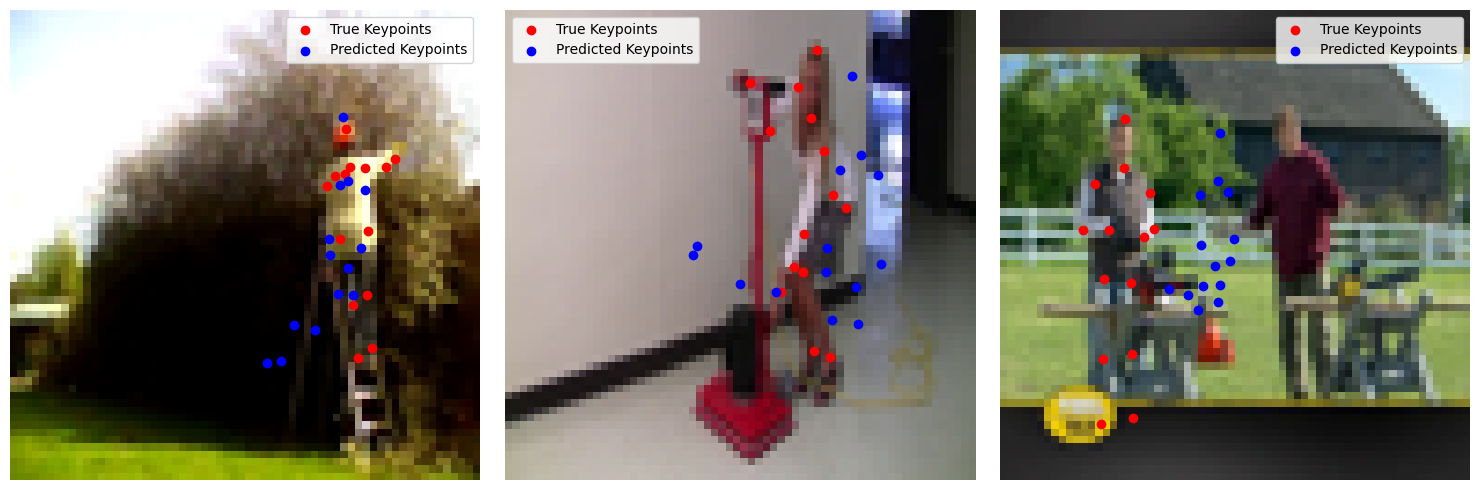

Epoch 25/50 completed in 463.49 seconds
Epoch 26/50


Train Loss: 0.5585
Test Loss: 0.6155, Accuracy: 0.1436


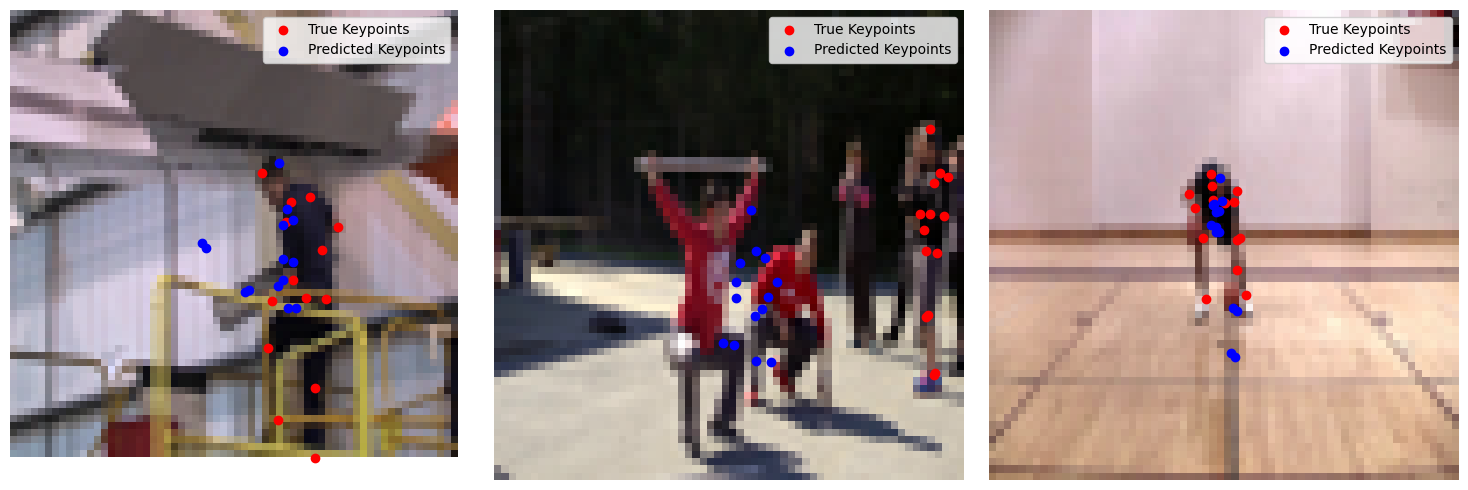

Epoch 26/50 completed in 467.68 seconds
Epoch 27/50


Train Loss: 0.5524
Test Loss: 0.6301, Accuracy: 0.1252


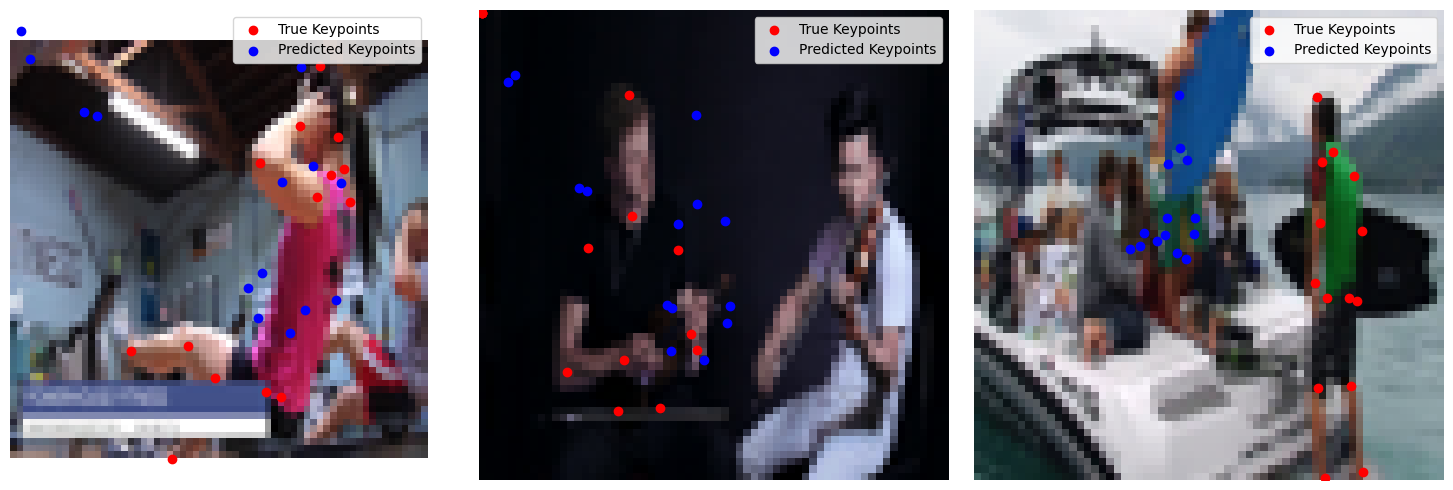

Epoch 27/50 completed in 469.94 seconds
Epoch 28/50


Train Loss: 0.5503
Test Loss: 0.6252, Accuracy: 0.1514


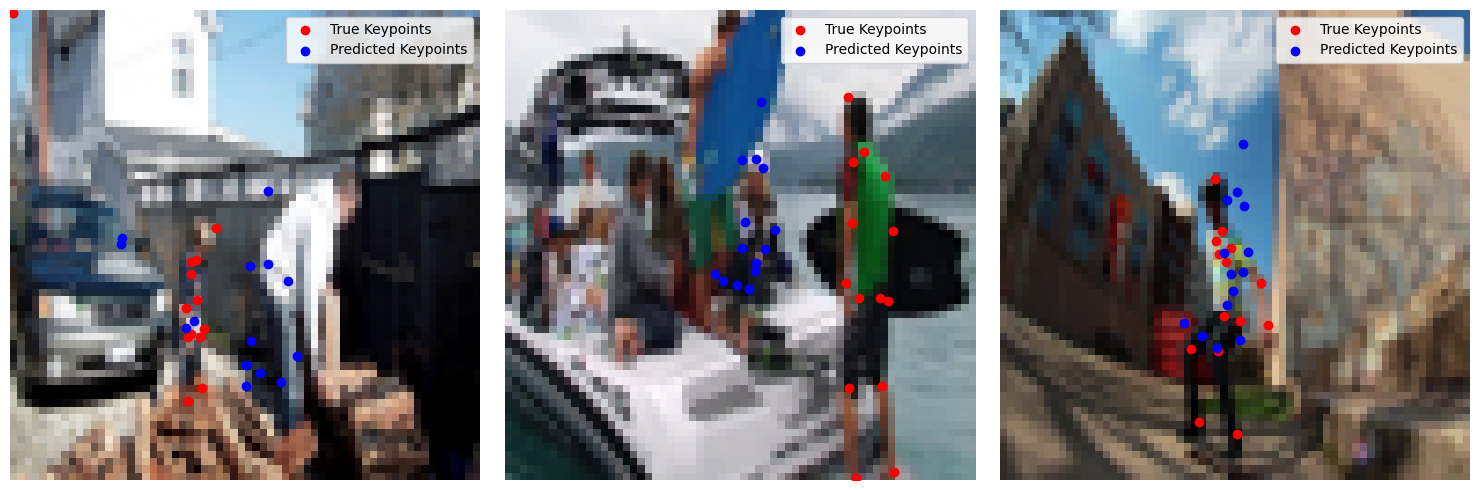

Epoch 28/50 completed in 466.86 seconds
Epoch 29/50


Train Loss: 0.5453
Test Loss: 0.6068, Accuracy: 0.1519


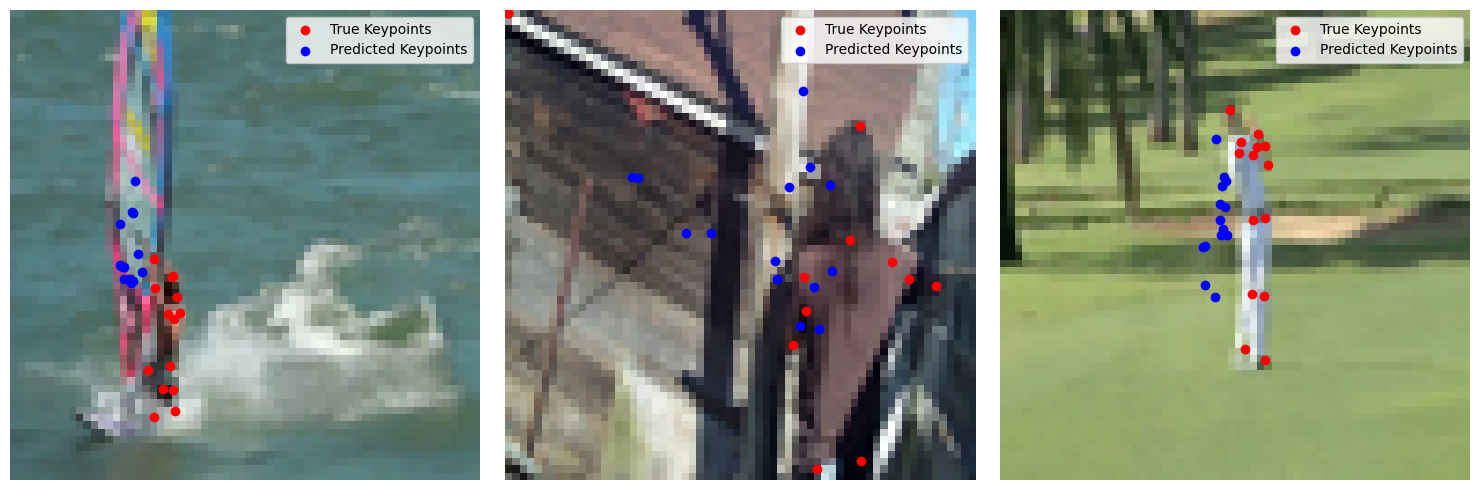

Epoch 29/50 completed in 465.86 seconds
Epoch 30/50


Train Loss: 0.5355
Test Loss: 0.6154, Accuracy: 0.1315


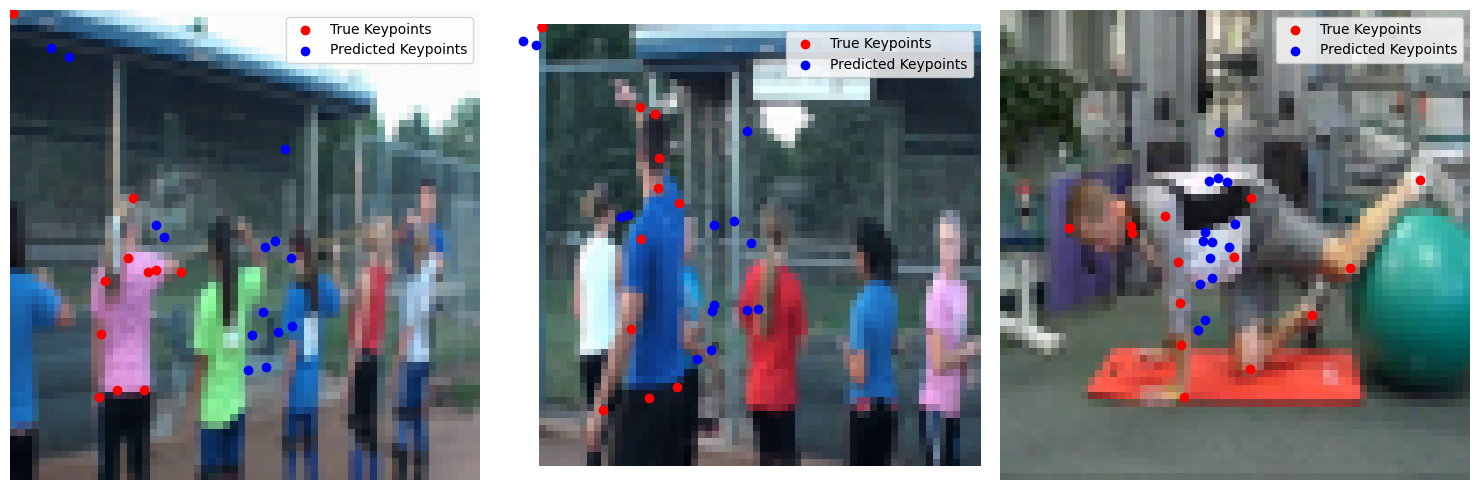

Epoch 30/50 completed in 500.77 seconds
Epoch 31/50


Train Loss: 0.5321
Test Loss: 0.6344, Accuracy: 0.1148


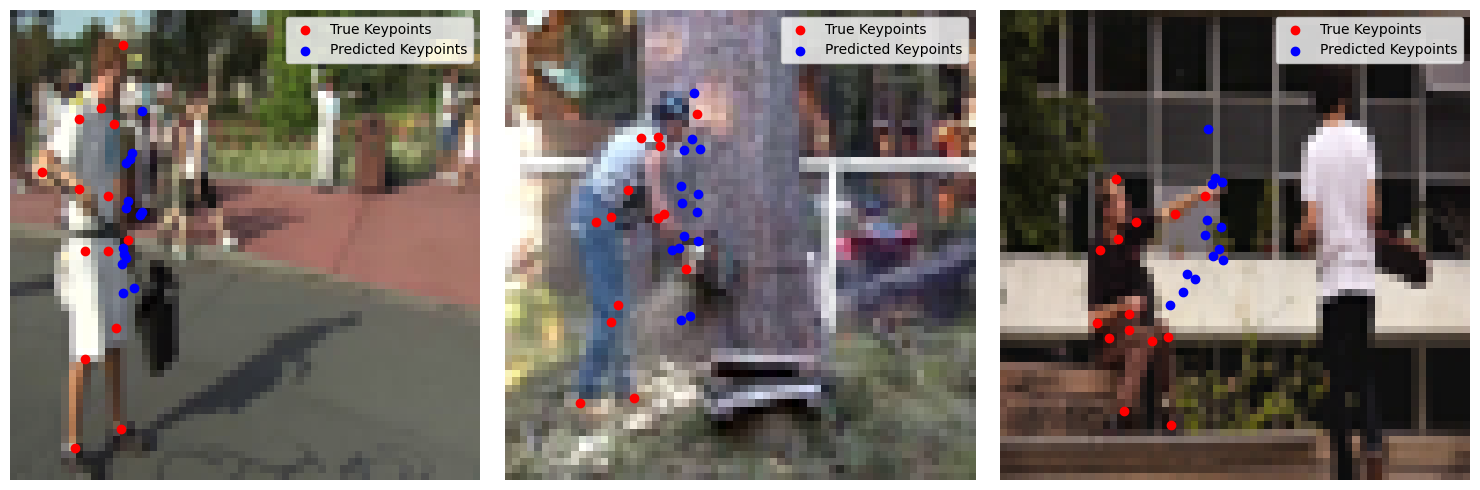

Epoch 31/50 completed in 587.91 seconds
Epoch 32/50


Train Loss: 0.5255
Test Loss: 0.5998, Accuracy: 0.1574


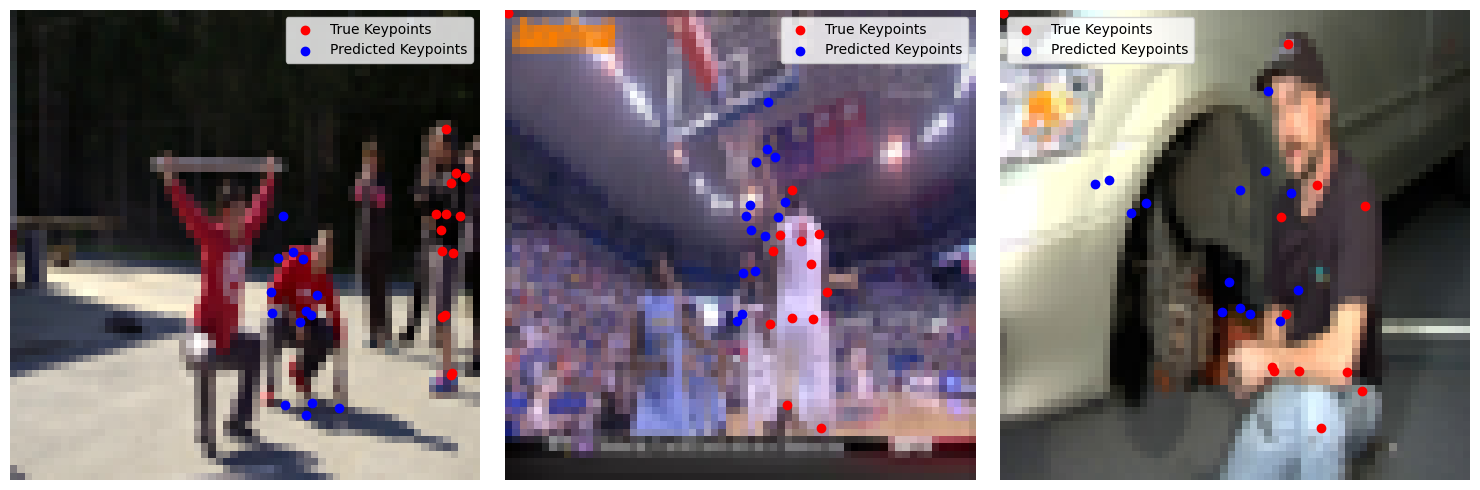

Epoch 32/50 completed in 524.85 seconds
Epoch 33/50


Train Loss: 0.5220
Test Loss: 0.6063, Accuracy: 0.1629


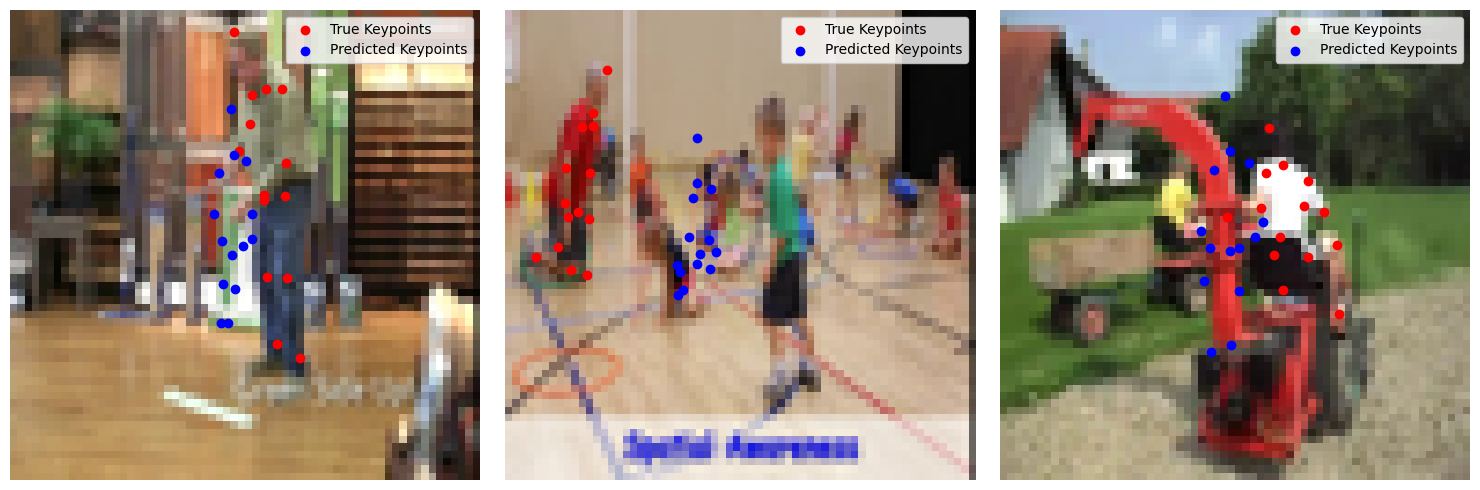

Epoch 33/50 completed in 480.50 seconds
Epoch 34/50


Train Loss: 0.5132
Test Loss: 0.6123, Accuracy: 0.1554


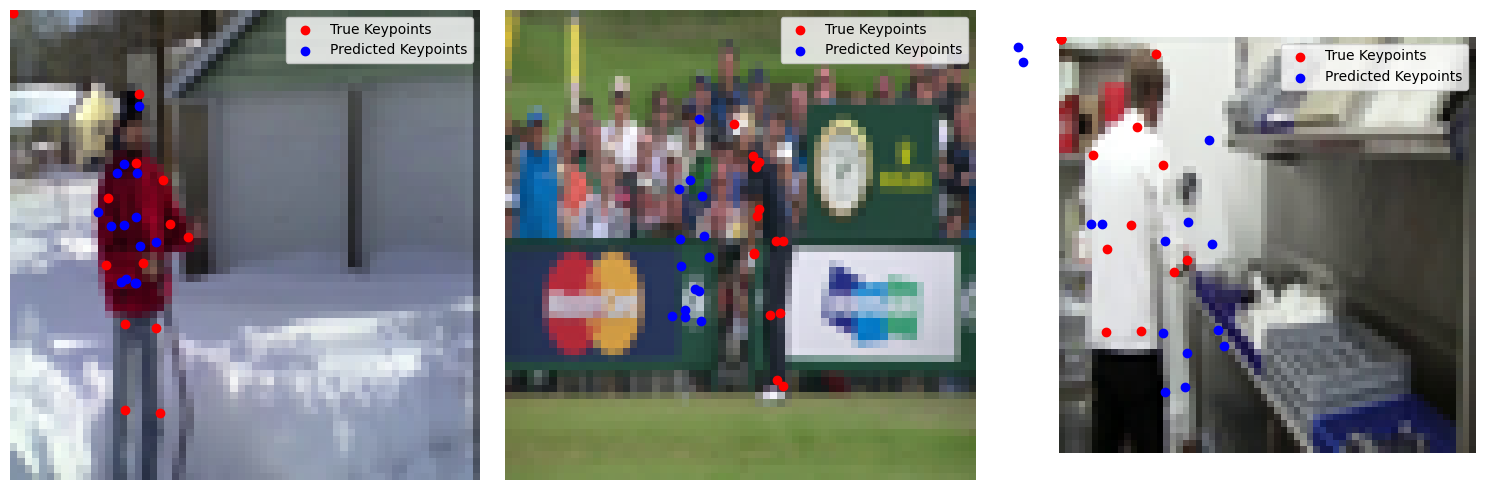

Epoch 34/50 completed in 479.35 seconds
Epoch 35/50


Train Loss: 0.5083
Test Loss: 0.6031, Accuracy: 0.1528


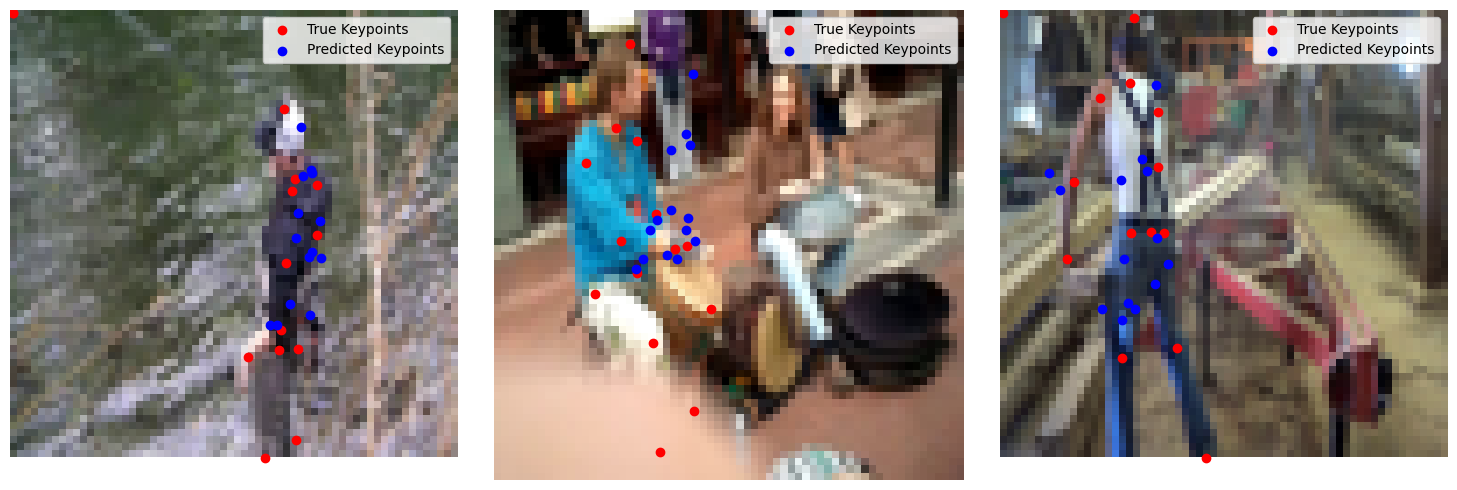

Epoch 35/50 completed in 480.32 seconds
Epoch 36/50


Train Loss: 0.5004
Test Loss: 0.6017, Accuracy: 0.1511


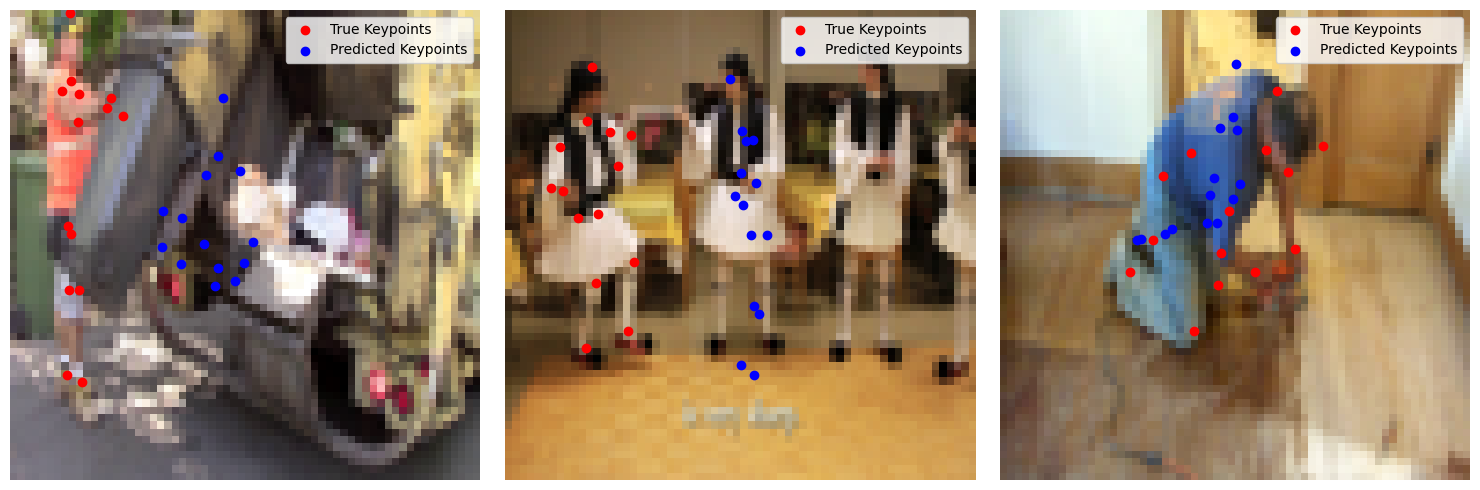

Epoch 36/50 completed in 480.79 seconds
Epoch 37/50


Train Loss: 0.4955
Test Loss: 0.6147, Accuracy: 0.1456


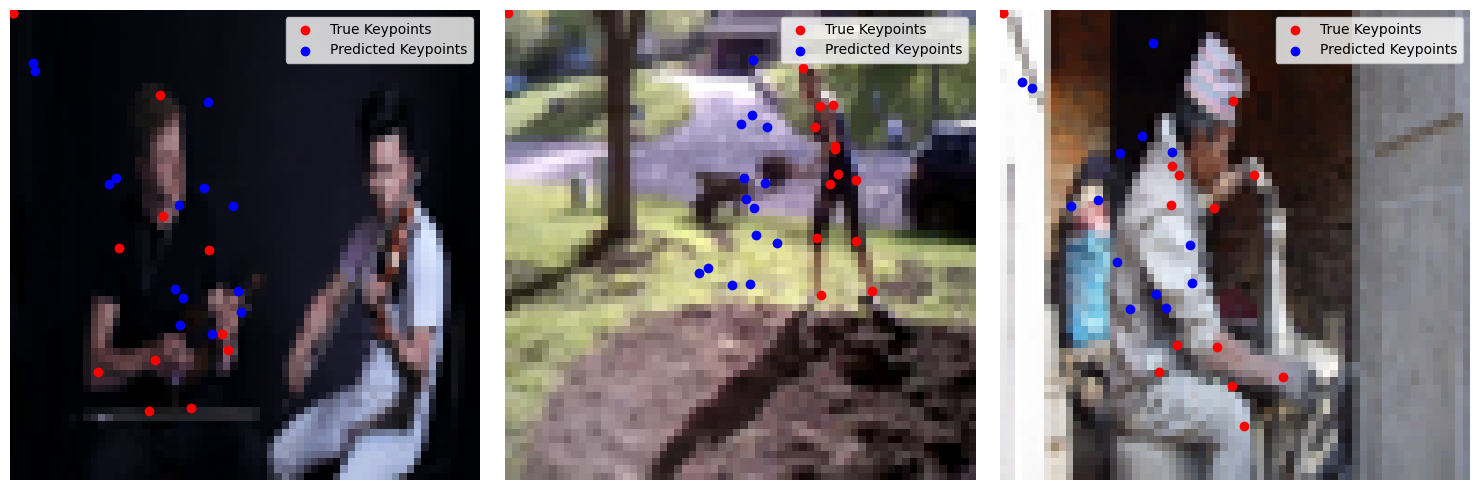

Epoch 37/50 completed in 482.61 seconds
Epoch 38/50


Train Loss: 0.4960
Test Loss: 0.5977, Accuracy: 0.1683


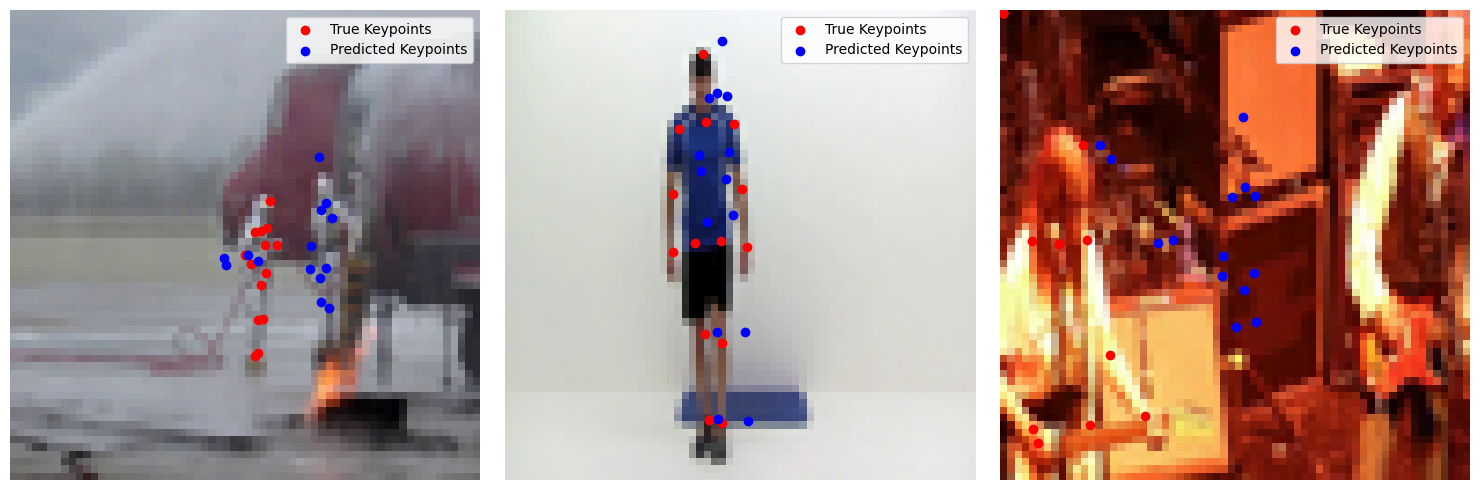

Epoch 38/50 completed in 489.52 seconds
Epoch 39/50


Train Loss: 0.4809
Test Loss: 0.5976, Accuracy: 0.1606


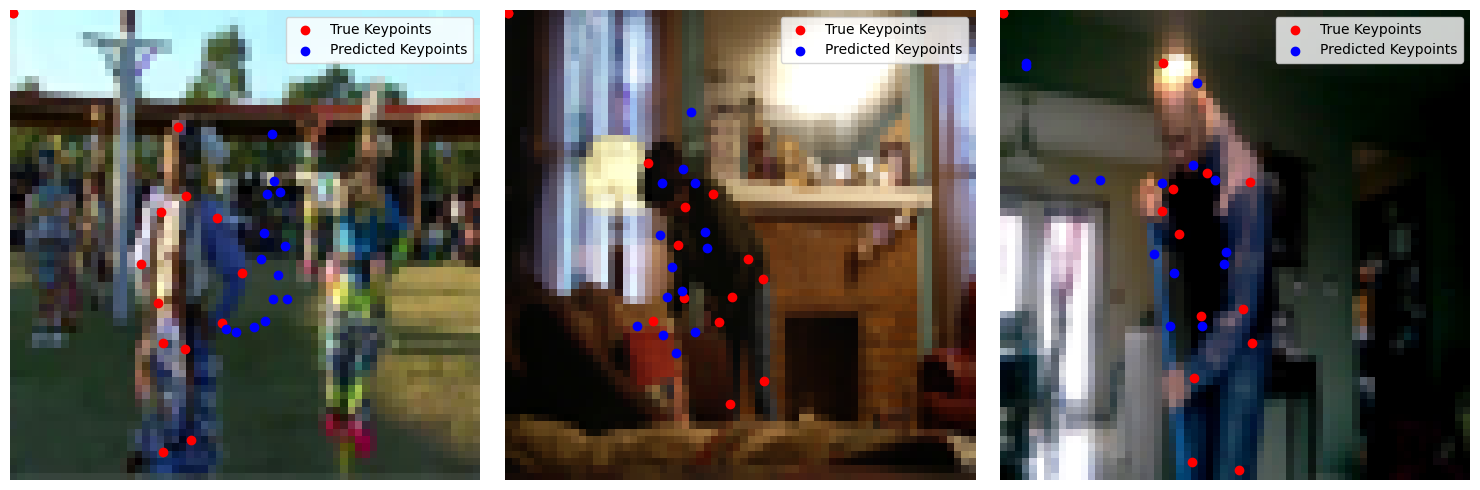

Epoch 39/50 completed in 497.88 seconds
Epoch 40/50


Train Loss: 0.4773
Test Loss: 0.6013, Accuracy: 0.1583


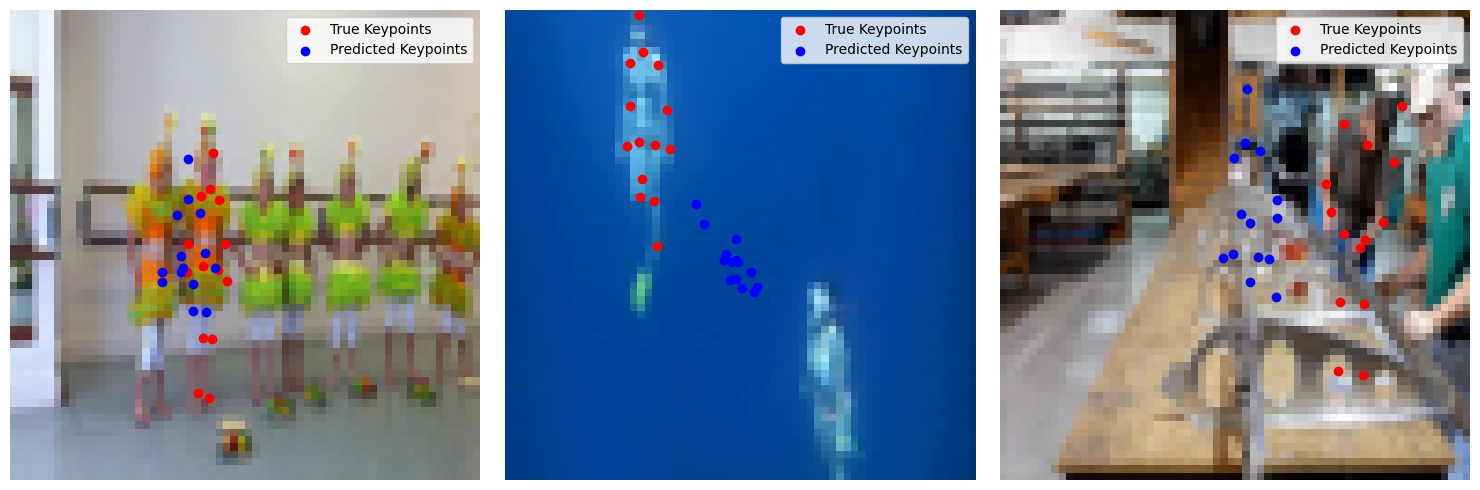

Epoch 40/50 completed in 565.72 seconds
Epoch 41/50


Train Loss: 0.4706
Test Loss: 0.6033, Accuracy: 0.1801


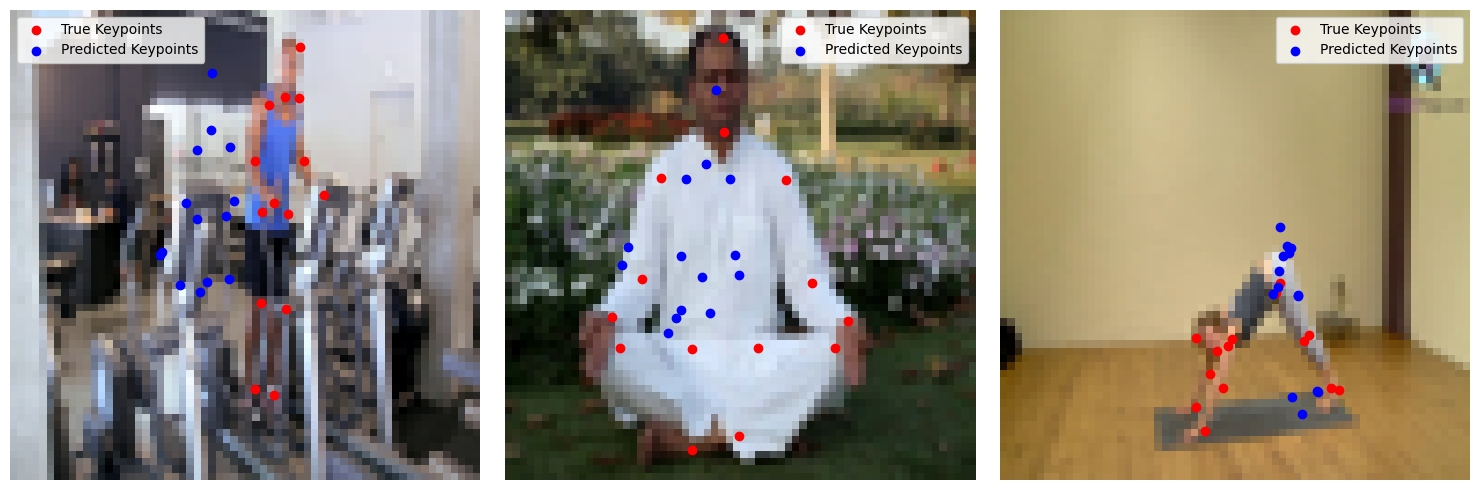

Epoch 41/50 completed in 482.40 seconds
Epoch 42/50


Train Loss: 0.4698
Test Loss: 0.6275, Accuracy: 0.1370


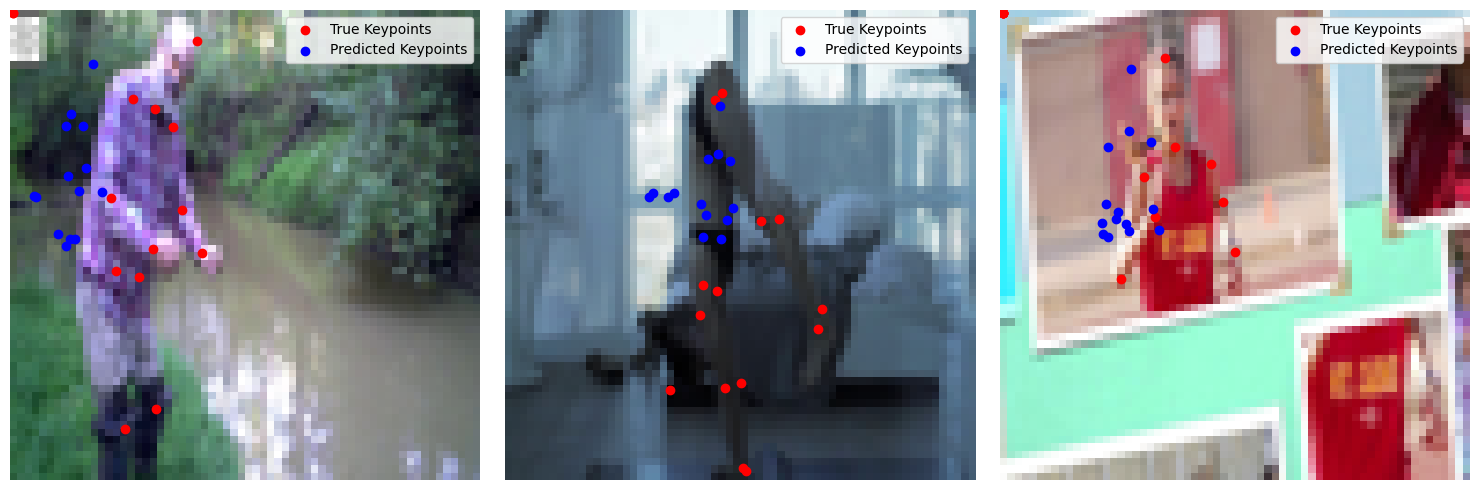

Epoch 42/50 completed in 485.08 seconds
Epoch 43/50


Train Loss: 0.4585
Test Loss: 0.6088, Accuracy: 0.1620


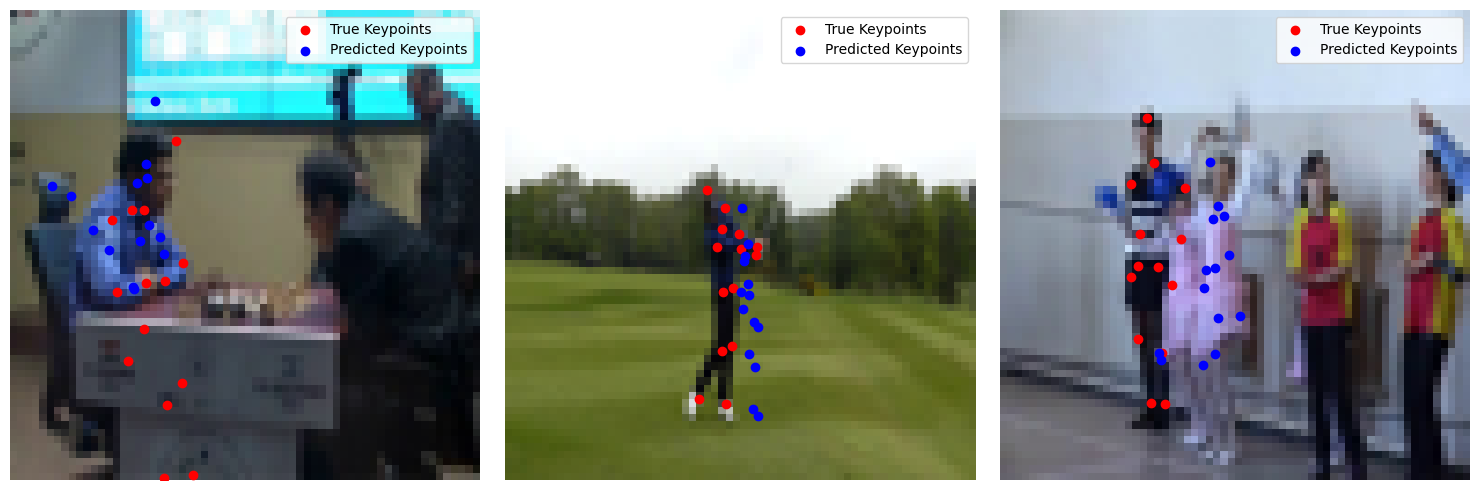

Epoch 43/50 completed in 480.51 seconds
Epoch 44/50


Train Loss: 0.4481
Test Loss: 0.6126, Accuracy: 0.1519


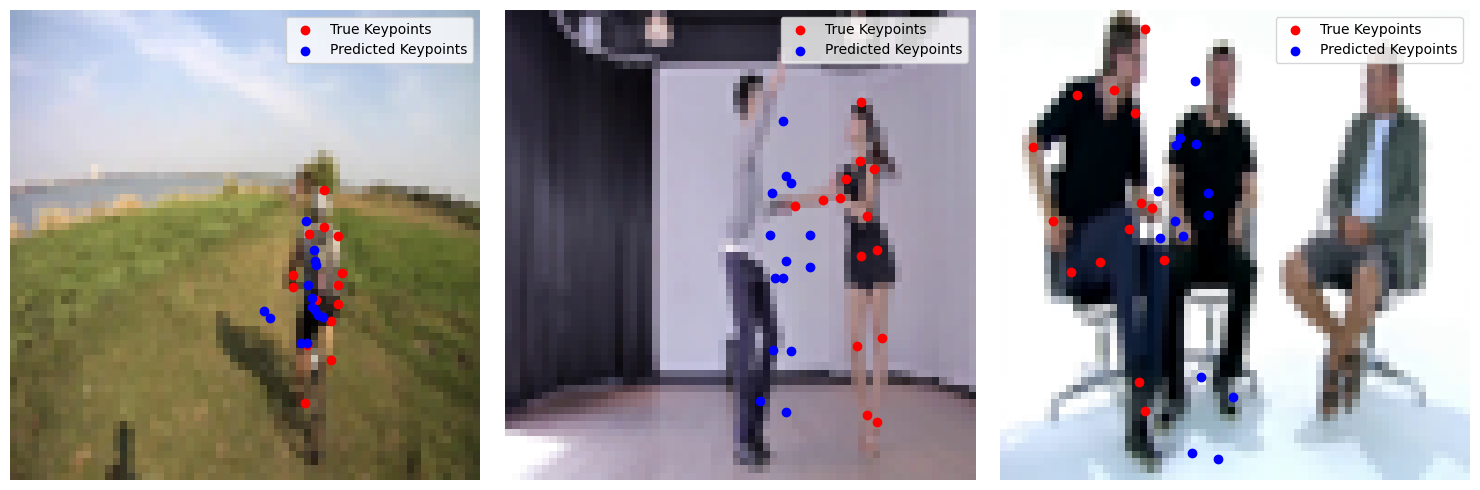

Epoch 44/50 completed in 484.67 seconds
Epoch 45/50


Train Loss: 0.4448
Test Loss: 0.6055, Accuracy: 0.1804


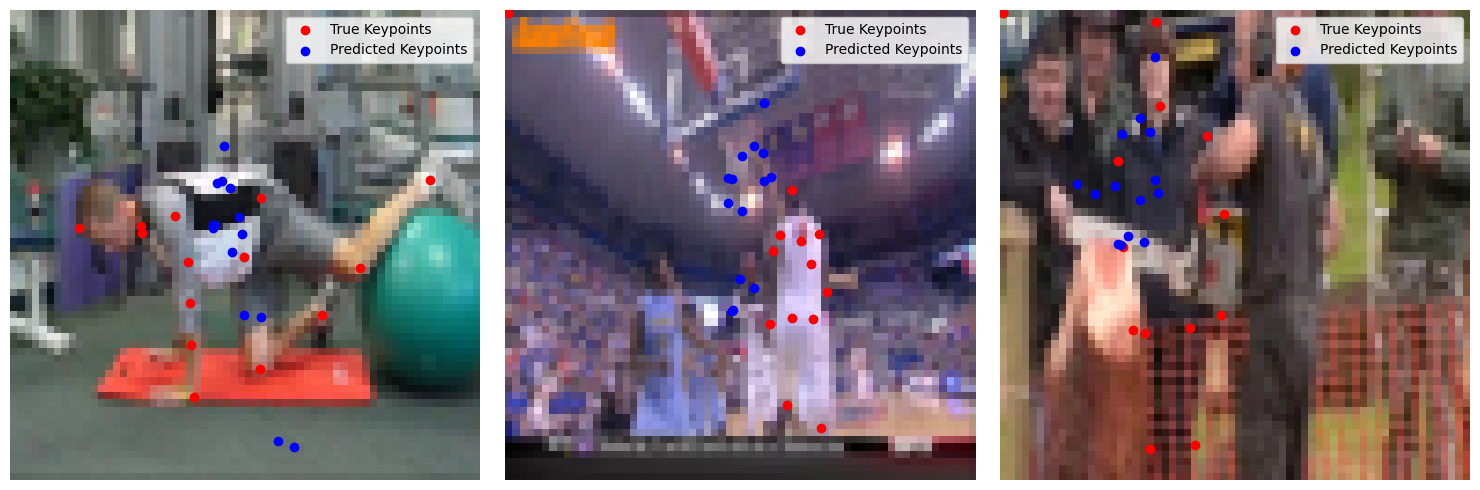

Epoch 45/50 completed in 482.06 seconds
Epoch 46/50


Train Loss: 0.4378
Test Loss: 0.6168, Accuracy: 0.1704


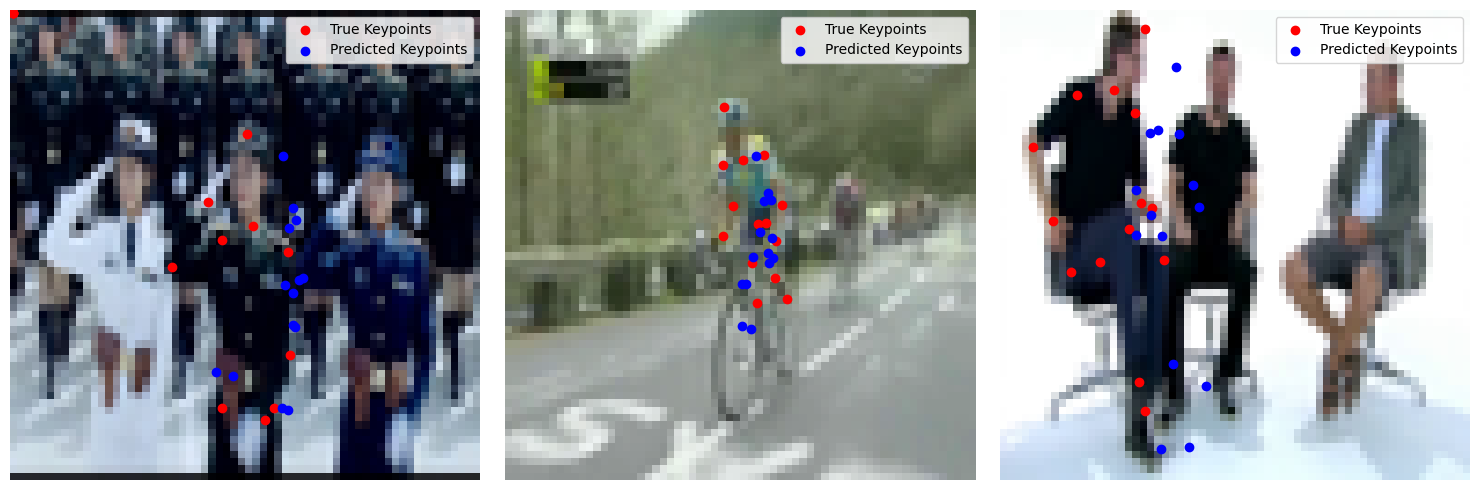

Epoch 46/50 completed in 488.90 seconds
Epoch 47/50


Train Loss: 0.4293
Test Loss: 0.5996, Accuracy: 0.1692


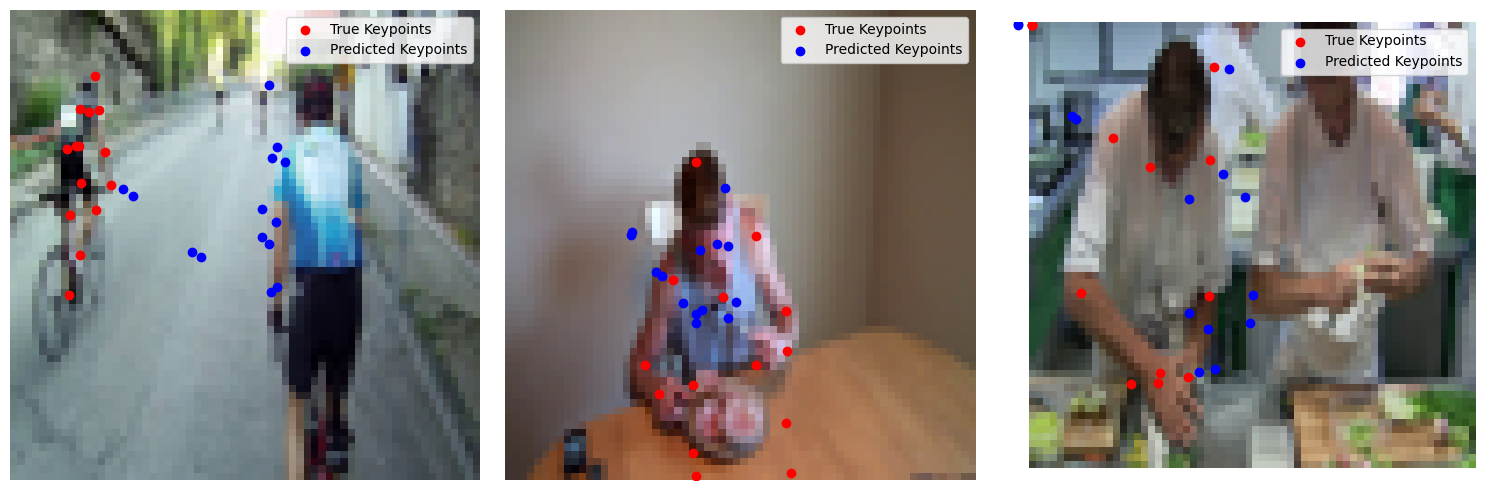

Epoch 47/50 completed in 482.36 seconds
Epoch 48/50


Train Loss: 0.4214
Test Loss: 0.6113, Accuracy: 0.1514


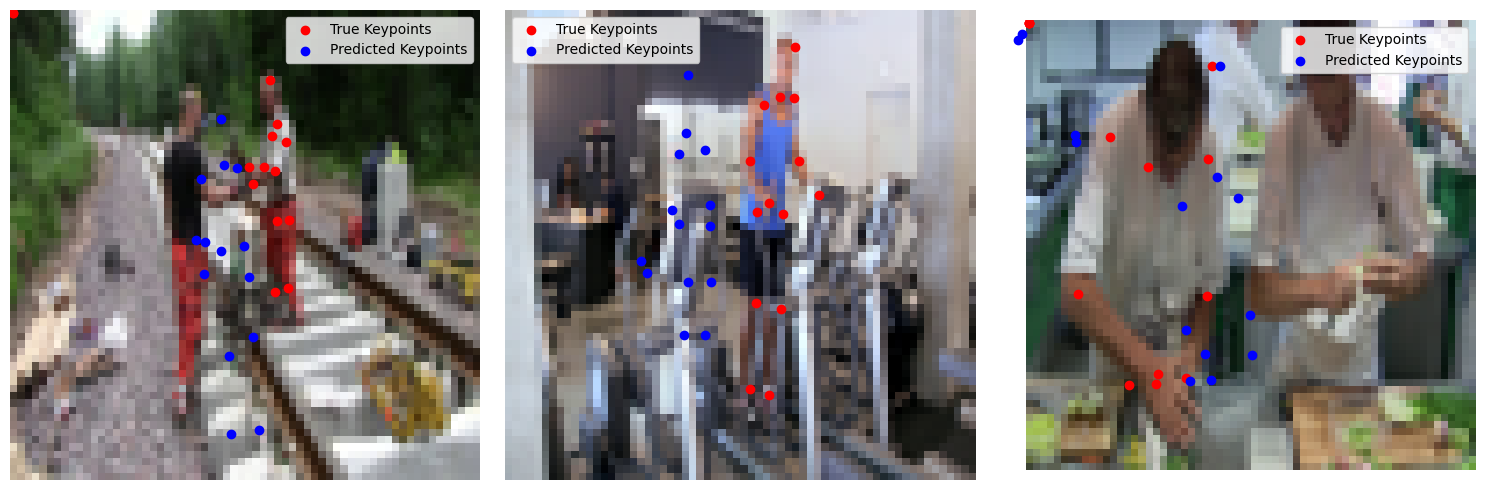

Epoch 48/50 completed in 489.30 seconds
Epoch 49/50


Train Loss: 0.4140
Test Loss: 0.5957, Accuracy: 0.1784


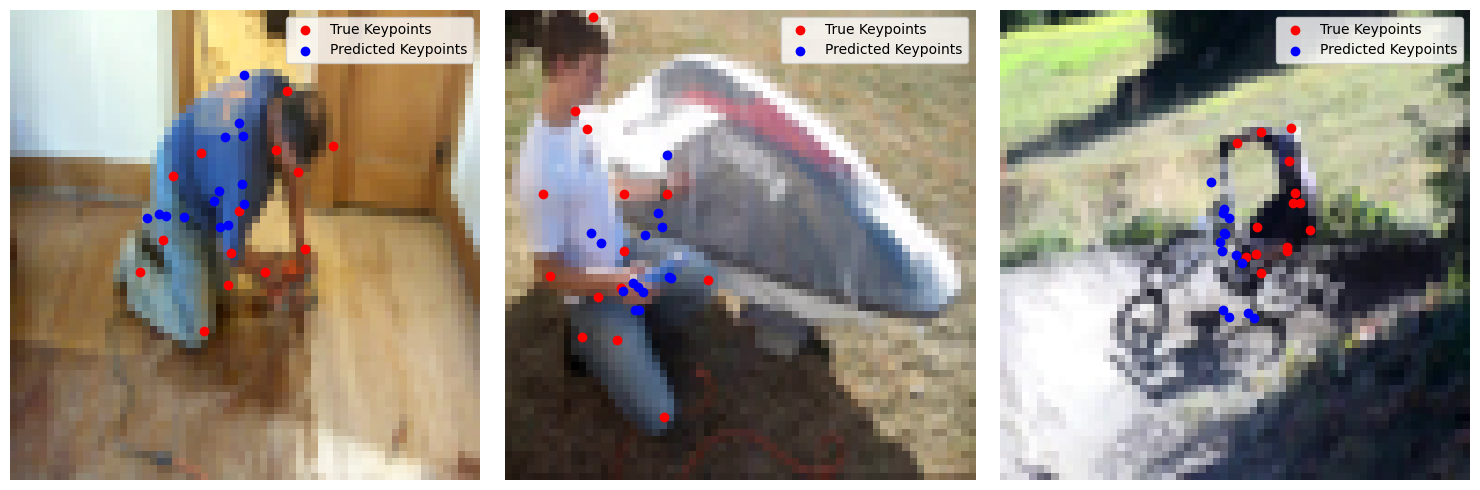

Epoch 49/50 completed in 481.63 seconds
Epoch 50/50


Train Loss: 0.4032
Test Loss: 0.6070, Accuracy: 0.1620


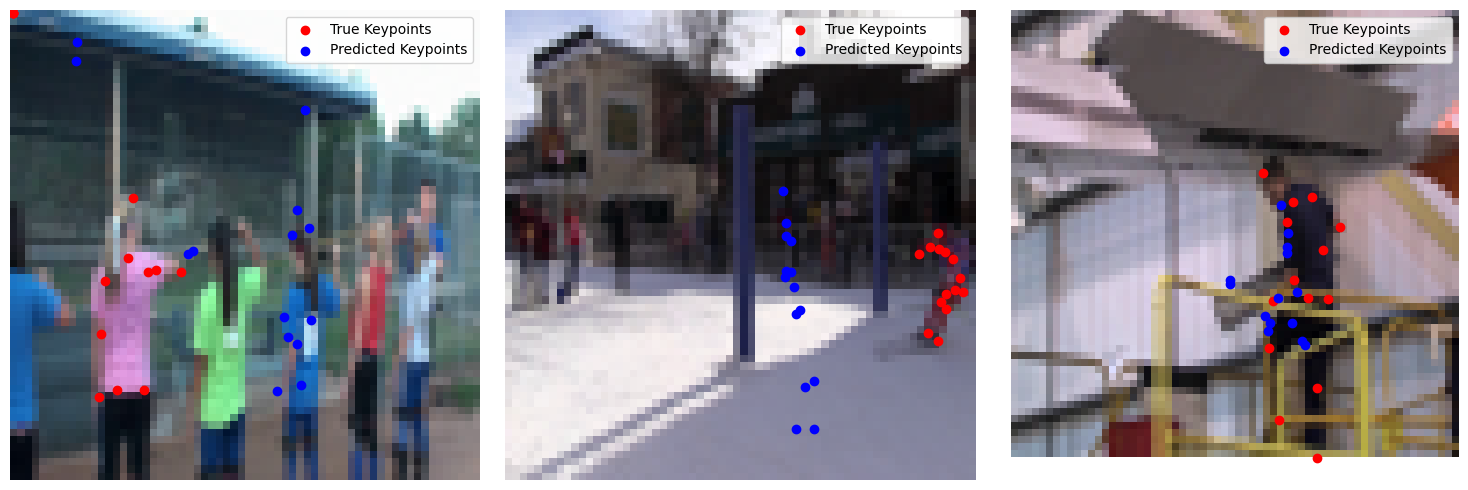

Epoch 50/50 completed in 485.15 seconds
Training complete. Total time: 24132.32 seconds


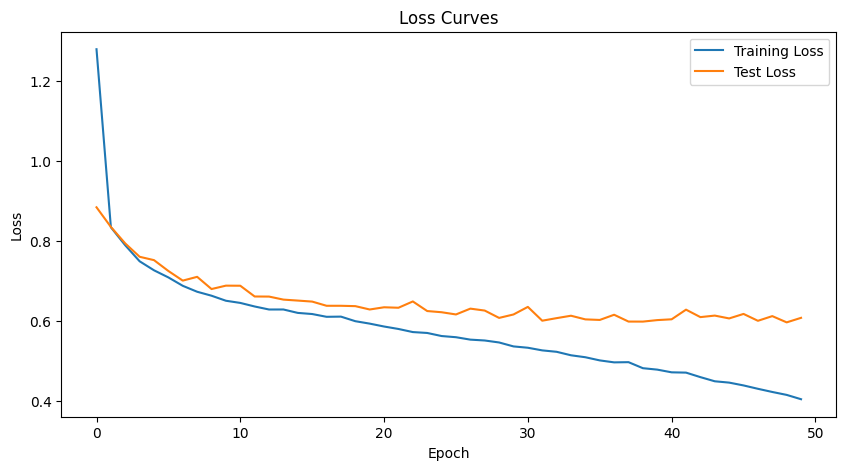

In [22]:
class KeypointLoss(nn.Module):
    def forward(self, preds, keypoints):
        with torch.no_grad():
            mask = 1 - (keypoints == -1).float()
        
        distances = torch.square(preds - keypoints) * mask
        return distances.mean()

model = MyPoseNet()
criterion = KeypointLoss()  
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

train_model(model, train_dataloader, test_dataloader, criterion, optimizer, num_epochs=50, device='cuda' if torch.cuda.is_available() else 'cpu')
